In [ ]:
!pip install -q flwr[simulation] flwr_datasets[vision] torch torchvision matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.7/364.7 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.1/65.1 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 86.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 42.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Standard library imports
from os.path import join
from collections import OrderedDict
from array import array

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from collections import defaultdict
import random

# Type hinting imports
from typing import Callable, Dict, List, Optional, Tuple, Any  # For type annotations

# Google Colab specific imports
from google.colab import drive
drive.mount('/content/drive')

# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split, Subset
import torchvision
import torchvision.transforms as transforms

# torchvision imports
import torchvision.transforms as transforms  # For image transformations

# Flower (Federated Learning) imports
import flwr as fl  # Core Flower framework
from flwr.common import (  # Common Flower types and functions
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    MetricsAggregationFn,
    NDArrays,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.server.client_manager import ClientManager  # For managing clients on server-side
from flwr.server.client_proxy import ClientProxy  # For server-side client proxy management

# Device setup
DEVICE = torch.device("cpu")  # Try "cuda" to train on GPU
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)


Mounted at /content/drive
Training on cpu using PyTorch 2.3.0+cu121 and Flower 1.9.0


# Load Data

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 32

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Files already downloaded and verified
Files already downloaded and verified


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


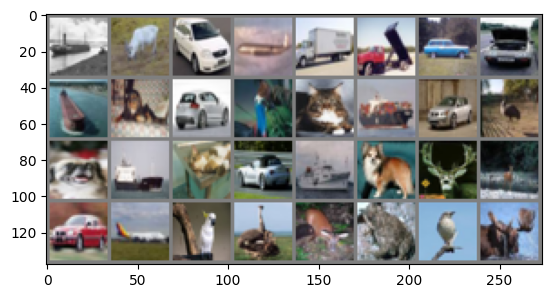

ship  deer  car   plane truck truck car   car   ship  dog   car   bird  cat   ship  car   bird  dog   ship  cat   car   ship  dog   deer  deer  car   plane bird  bird  deer  frog  bird  deer 
50000
10000
torch.Size([32, 3, 32, 32])
torch.Size([32])


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))
print(len(trainset))
print(len(testset))
print(images.shape)
print(labels.shape)

# Generate balanced data and unbalanced data

In [ ]:
def split_dataset_balanced(num_clients, train_dataset, test_dataset, batch_size=32):
    """
    Splits the given training and testing data into balanced subsets for a given number of clients
    and returns lists of DataLoader objects.
    """
    # Create datasets
    # train_dataset = CustomDataset(X_train, y_train)
    # test_dataset = CustomDataset(X_test, y_test)

    def create_balanced_subsets(dataset, num_clients):

        # Group indices by label
        label_to_indices = defaultdict(list)
        for idx in range(len(dataset)):
                _, label = dataset[idx]
                label_to_indices[label].append(idx)

        # Find the minimum number of samples for any label
        min_label_count = min(len(indices) for indices in label_to_indices.values())

        # Determine the number of samples per client per label
        samples_per_client_per_label = min_label_count // num_clients

        # Create an array to hold indices for each client
        client_indices = [[] for _ in range(num_clients)]

        # Distribute indices for each label to each client
        for label, indices in label_to_indices.items():
            np.random.shuffle(indices)  # Shuffle indices to ensure randomness
            for i in range(num_clients):
                start_idx = i * samples_per_client_per_label
                end_idx = (i + 1) * samples_per_client_per_label
                client_indices[i].extend(indices[start_idx:end_idx])

        # Create subsets for each client
        subsets = [Subset(dataset, indices) for indices in client_indices]

        return subsets

    # Create balanced subsets for train and test datasets
    train_subsets = create_balanced_subsets(train_dataset, num_clients)
    test_subsets = create_balanced_subsets(test_dataset, num_clients)

    # Create DataLoaders for each subset
    train_loaders = [DataLoader(subset, batch_size=batch_size, shuffle=True) for subset in train_subsets]
    test_loaders = [DataLoader(subset, batch_size=batch_size, shuffle=False) for subset in test_subsets]

    return train_loaders, test_loaders

def create_unbalanced_loaders(train_loaders, test_loaders, label_counts, alpha):
    """
    Converts balanced train and test DataLoader objects into unbalanced DataLoader objects by redistributing the samples.

    """

    def create_unbalanced_loader(loader, p):
        label_to_indices = defaultdict(list)
        dataset = loader.dataset

        # Build the mapping from labels to indices
        for idx in range(len(dataset)):
            _, label = dataset[idx]
            label_to_indices[label].append(idx)

        subset_indices = []
        for label, indices_list in label_to_indices.items():
            prob = p[label]
            for idx in indices_list:
                if np.random.rand() < prob:
                    subset_indices.append(idx)

        subset_dataset = Subset(dataset, subset_indices)
        subset_loader = DataLoader(subset_dataset, batch_size=loader.batch_size, shuffle=True)

        return subset_loader

    unbalanced_train_loaders = []
    unbalanced_test_loaders = []
    for i in range(len(train_loaders)):

        train_loader = train_loaders[i]
        test_loader = test_loaders[i]

        # Generate Dirichlet distribution to get probabilities
        p = np.random.dirichlet([alpha] * label_counts)

        # Normalize probabilities
        p /= np.max(p)

        unbalanced_train_loaders.append(create_unbalanced_loader(train_loader, p))
        unbalanced_test_loaders.append(create_unbalanced_loader(test_loader, p))

    return unbalanced_train_loaders, unbalanced_test_loaders


In [ ]:
test_balanced_train_loaders, test_balanced_test_loaders = split_dataset_balanced(num_clients=10, train_dataset=trainset, test_dataset=testset, batch_size=32)

test_unbalanced_train_loaders, test_unbalanced_test_loaders = create_unbalanced_loaders(test_balanced_train_loaders, test_balanced_test_loaders, label_counts=10, alpha=0.5)

# Plot label distribution

In [ ]:
def get_labels_from_subset(subset):
    labels = []
    for _, label in subset:
        labels.append(label)
    return labels

def plot_label_distribution(train_loaders):
    client_number = len(train_loaders)
    row = math.ceil(client_number / 5)
    fig, axs = plt.subplots(row, 5, figsize=(10, row * 2))  # Adjusted figsize for better visibility
    axs = axs.flatten()  # Flatten the array of axes for easier indexing

    for i, data_loader in enumerate(train_loaders):
        client_dataset = data_loader.dataset
        labels = get_labels_from_subset(client_dataset)
        label_counts = np.bincount(labels)
        # print(label_counts)

        ax = axs[i]
        cmap = plt.cm.YlGnBu  # Choose colormap
        colors = cmap(np.linspace(0.1, 0.9, len(label_counts)))  # Generate colors
        ax.bar(range(len(label_counts)), label_counts, color=colors)
        ax.set_xlabel('Label')
        ax.set_ylabel('Count')
        ax.set_title(f'Client {i + 1}')

    # Hide any unused subplots
    for j in range(len(train_loaders), len(axs)):
        fig.delaxes(axs[j])

    # Adjust layout and display the plots
    plt.tight_layout()
    plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


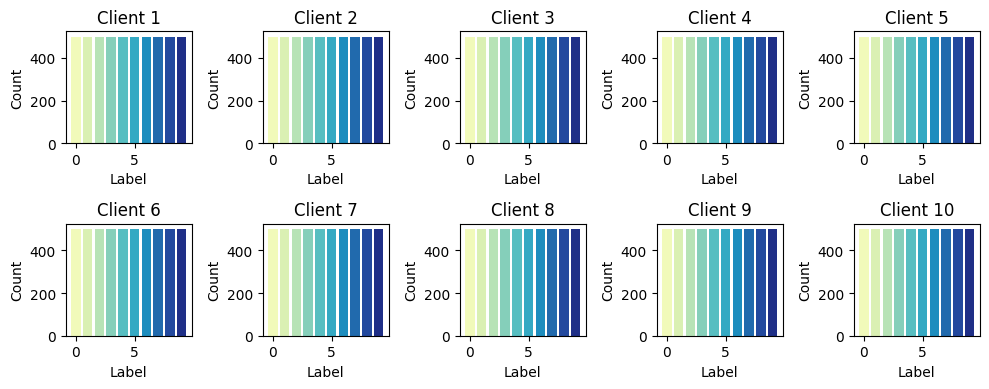

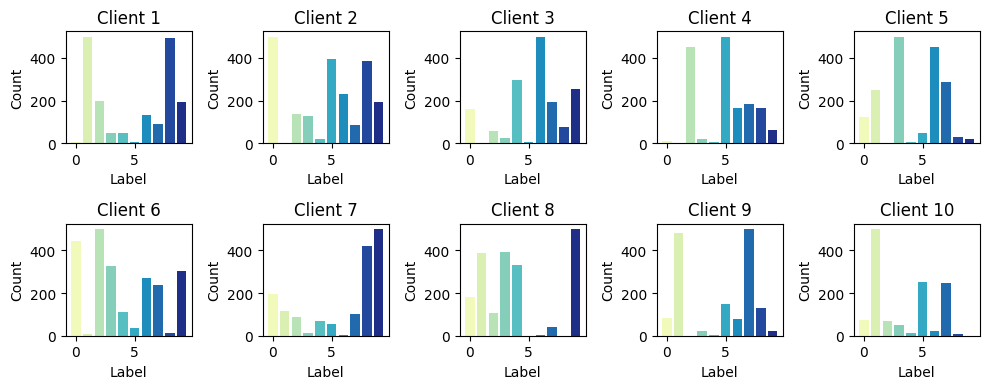

In [ ]:
plot_label_distribution(test_balanced_train_loaders)
plot_label_distribution(test_unbalanced_train_loaders)

# CNN

In [ ]:
def train(net, trainloader, epochs):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    for _ in range(epochs):
        for images, labels in trainloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            loss = criterion(net(images), labels)
            loss.backward()
            optimizer.step()

def test(net, testloader):
    """Validate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(DEVICE), data[1].to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    return loss, accuracy

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [ ]:
net = Net().to(DEVICE)
train(net, trainloader, epochs=5)
loss, accuracy = test(net, testloader)
print('Loss: %f, Accuracy: %f' % (loss, accuracy))

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss: 430.040280, Accuracy: 0.497700


# Client

In [ ]:
class Client(fl.client.NumPyClient):
    def __init__(self, net, train_loader, test_loader, num_examples):
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.net = net
        self.num_examples = num_examples

    def get_parameters(self, config):
        return [val.cpu().numpy() for _, val in self.net.state_dict().items()]

    def set_parameters(self, parameters):
        params_dict = zip(self.net.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
        self.net.load_state_dict(state_dict, strict=True)

    def fit(self, parameters, config):
        self.set_parameters(parameters)
        train(self.net, self.train_loader, epochs=4)
        _, accuracy = test(self.net, self.test_loader)
        return self.get_parameters(config={}), self.num_examples["trainset"], {"accuracy": accuracy}

    def evaluate(self, parameters, config):
        self.set_parameters(parameters)
        loss, accuracy = test(self.net, self.test_loader)
        return float(loss), self.num_examples["testset"], {"accuracy": float(accuracy)}

In [ ]:
def get_client_fn(train_loaders, test_loaders, num_examples):
    """Return a function to construct a client.

    """

    def client_fn(cid: str) -> Client:
        train_loader = train_loaders[int(cid)]
        test_loader = test_loaders[int(cid)]
        net = Net().to(DEVICE)

        # print(f"cid: {int(cid)}")

        return Client(net, train_loader, test_loader, num_examples).to_client()

    return client_fn

# Strategy

## Method A

In [ ]:
class MethodA(fl.server.strategy.FedAvg):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.accuracies = []
        self.losses = []
        self.accuracy_df = pd.DataFrame()

    def aggregate_evaluate(
        self,
        rnd: int,
        results: List[Tuple[fl.server.client_proxy.ClientProxy, fl.common.EvaluateRes]],
        failures: List[BaseException]
    ) -> Tuple[float, Dict[str, Any]]:

        # Calculate accuracies for each client, create a dictionary and DataFrame for the round, and compute the mean accuracy
        round_accuracies = [result.metrics["accuracy"] for _, result in results]
        round_accuracy_dict = {f"Client {client_idx + 1}": accuracy for client_idx, accuracy in enumerate(round_accuracies)}
        round_df = pd.DataFrame(round_accuracy_dict, index=[rnd])
        accuracy = np.mean(round_accuracies)


        # Update accuracies, losses, and the accuracy DataFrame with the current round's data
        self.accuracies.append(accuracy)
        self.losses.append([result.loss for _, result in results])
        self.accuracy_df = pd.concat([self.accuracy_df, round_df])


        return super().aggregate_evaluate(rnd, results, failures)

    def plot_accuracies(self):
        plt.figure()
        plt.plot(range(1, len(self.accuracies) + 1), self.accuracies, marker='o')
        plt.title("Accuracy per Round")
        plt.xlabel("Round")
        plt.ylabel("Accuracy")
        plt.grid()
        plt.show()

    def plot_loss_per_client_per_round(self):
        num_rounds = len(self.losses)
        num_clients = len(self.losses[0])

        plt.figure()
        for client_idx in range(num_clients):
            plt.plot(range(1, num_rounds + 1), [self.losses[r][client_idx] for r in range(num_rounds)], marker='o', label=f'Client {client_idx + 1}')

        plt.title("Loss per Client per Round")
        plt.xlabel("Round")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid()
        plt.show()

    def print_accuracy_matrix(self):
        print("Classification Accuracy Matrix:")
        print(self.accuracy_df)


    def save_accuracy_matrix(self, file_path):
        self.accuracy_df.to_csv(file_path, index_label='Round')

## Method B

In [ ]:
class MethodB(fl.server.strategy.FedAvg):
    def __init__(self, p, num_clients, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.p = p  # Fraction of clients to select
        self.num_clients = num_clients
        self.accuracies = []
        self.losses = []
        self.accuracy_df = pd.DataFrame()

        self.selected_clients = []  # To store selected clients
        self.probability_df = pd.DataFrame()

    def configure_fit(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, FitIns]]:

        sample_size = int(self.p * self.num_clients)
        all_clients = client_manager.all()
        selected_clients_cids = [client.cid for client in self.selected_clients]

        if(server_round == 1):
            # Round 1: All nodes have p probability of selection
            selected_clients = client_manager.sample(num_clients=sample_size, min_num_clients=sample_size)

            # store round probabilities
            round_probabilities = {f"Client {cid + 1}": self.p for cid in range(self.num_clients)}

        else:
            # Round t: Nodes have selection probability based on accuracy from previous round
            selected_clients = []
            round_probabilities = {}

            for client_cid in range(self.num_clients):
                client_key = f"Client {client_cid + 1}"

                if str(client_cid) in selected_clients_cids:
                    last_round_accuracy = self.accuracy_df[client_key].iloc[-1]
                    prob = np.exp(-1.5 * last_round_accuracy)
                else:
                    prob = self.p

                # store round probabilities
                round_probabilities[client_key] = prob

                if np.random.rand() < prob:
                    selected_clients.append(all_clients[str(client_cid)])

        # Ensure at least one client is selected
        if not selected_clients:
            selected_clients.append(all_clients[str(random.randint(0, self.num_clients - 1))])

        # update selected clients
        self.selected_clients = selected_clients

        # Update probability dataframe
        prob_df = pd.DataFrame(round_probabilities, index=[server_round])
        self.probability_df = pd.concat([self.probability_df, prob_df])

        fit_ins = FitIns(parameters, {})

        print(f"Serial number of the client selected to fit: {[client.cid for client in self.selected_clients]}")
        return [(client, fit_ins) for client in self.selected_clients]

    def configure_evaluate(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, EvaluateIns]]:

        # Use only selected clients for evaluation
        evaluate_clients = self.selected_clients

        config = {}
        evaluate_ins = EvaluateIns(parameters, config)

        # Return client/config pairs for evaluation
        print(f"Serial number of the client selected to evaluate: {[client.cid for client in evaluate_clients]}")
        return [(client, evaluate_ins) for client in evaluate_clients]

    def aggregate_evaluate(
        self,
        rnd: int,
        results: List[Tuple[fl.server.client_proxy.ClientProxy, fl.common.EvaluateRes]],
        failures: List[BaseException]
    ) -> Tuple[float, Dict[str, Any]]:

        # Initialize dictionaries to store evaluated client accuracy
        evaluated_client_dict = {}
        round_accuracy_dict = {}

        for client_proxy, evaluate_res in results:
            # Assume evaluate_res has an 'accuracy' attribute
            client_cid = int(client_proxy.cid)
            accuracy = evaluate_res.metrics["accuracy"]

            evaluated_client_dict[client_cid] = accuracy

        # Generate accuracy dict for all clients
        for client_cid in range(self.num_clients):
            client_key = f"Client {client_cid + 1}"
            if client_cid in evaluated_client_dict.keys():
                round_accuracy_dict[client_key] = evaluated_client_dict[client_cid]
            else:
                if(rnd == 1):
                    round_accuracy_dict[client_key] = float('NaN')
                else:
                    round_accuracy_dict[client_key] = self.accuracy_df[client_key].iloc[-1]

        round_accuracies = [result.metrics["accuracy"] for _, result in results]
        # round_accuracy_dict = {f"Client {client_idx + 1}": accuracy for client_idx, accuracy in enumerate(round_accuracies)}

        round_df = pd.DataFrame(round_accuracy_dict, index=[rnd])
        accuracy = np.mean(round_accuracies)

        self.accuracies.append(accuracy)
        self.losses.append([result.loss for _, result in results])
        self.accuracy_df = pd.concat([self.accuracy_df, round_df])

        return super().aggregate_evaluate(rnd, results, failures)

    def plot_accuracies(self):
        plt.figure()
        plt.plot(range(1, len(self.accuracies) + 1), self.accuracies, marker='o')
        plt.title("Accuracy per Round")
        plt.xlabel("Round")
        plt.ylabel("Accuracy")
        plt.grid()
        plt.show()

    def print_accuracy_matrix(self):
        print("Classification Accuracy Matrix:")
        print(self.accuracy_df)

    def save_accuracy_matrix(self, file_path):
        self.accuracy_df.to_csv(file_path, index_label='Round')

## Method C

In [ ]:
class MethodC(fl.server.strategy.FedAvg):
    def __init__(self, p, num_clients, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.p = p  # Fraction of clients to select
        self.num_clients = num_clients
        self.accuracies = [] # Store avg accuracies for each round
        self.losses = []
        self.accuracy_df = pd.DataFrame()

        self.selected_clients = []  # To store selected clients
        self.probability_df = pd.DataFrame()

    def configure_fit(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, FitIns]]:

        sample_size = int(self.p * self.num_clients)
        all_clients = client_manager.all()
        selected_clients_cids = [client.cid for client in self.selected_clients]

        print(f"server_round: {server_round}")

        if(server_round == 1):
            # Round 1: All nodes have p probability of selection
            selected_clients = client_manager.sample(num_clients=sample_size, min_num_clients=sample_size)

            # store round probabilities
            round_probabilities = {f"Client {cid + 1}": self.p for cid in range(self.num_clients)}

        else:
            print(f"server_round: {server_round}")
            # Round t: Nodes have selection probability based on accuracy from previous round
            selected_clients = []
            round_probabilities = {}

            for client_cid in range(self.num_clients):
                client_key = f"Client {client_cid + 1}"

                if str(client_cid) in selected_clients_cids:
                    last_round_accuracy = self.accuracy_df[client_key].iloc[-1]
                    prob = np.exp(-1.5 * last_round_accuracy)
                else:
                    prob = self.probability_df[client_key].iloc[-1]

                # store round probabilities
                round_probabilities[client_key] = prob

                if np.random.rand() < prob:
                    selected_clients.append(all_clients[str(client_cid)])

        # Ensure at least one client is selected
        if not selected_clients:
            selected_clients.append(all_clients[str(random.randint(0, self.num_clients - 1))])

        # update selected clients
        self.selected_clients = selected_clients

        # Update probability dataframe
        prob_df = pd.DataFrame(round_probabilities, index=[server_round])
        self.probability_df = pd.concat([self.probability_df, prob_df])

        fit_ins = FitIns(parameters, {})

        print(f"Serial number of the client selected to fit: {[client.cid for client in self.selected_clients]}")
        return [(client, fit_ins) for client in self.selected_clients]

    def configure_evaluate(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, EvaluateIns]]:

        # Use only selected clients for evaluation
        evaluate_clients = self.selected_clients

        config = {}
        evaluate_ins = EvaluateIns(parameters, config)

        # Return client/config pairs for evaluation
        print(f"Serial number of the client selected to evaluate: {[client.cid for client in evaluate_clients]}")
        return [(client, evaluate_ins) for client in evaluate_clients]

    def aggregate_evaluate(
        self,
        rnd: int,
        results: List[Tuple[fl.server.client_proxy.ClientProxy, fl.common.EvaluateRes]],
        failures: List[BaseException]
    ) -> Tuple[float, Dict[str, Any]]:

        # Initialize dictionaries to store evaluated client accuracy
        evaluated_client_dict = {}
        round_accuracy_dict = {}

        for client_proxy, evaluate_res in results:
            # Assume evaluate_res has an 'accuracy' attribute
            client_cid = int(client_proxy.cid)
            accuracy = evaluate_res.metrics["accuracy"]

            evaluated_client_dict[client_cid] = accuracy

        # Generate accuracy dict for all clients
        for client_cid in range(self.num_clients):
            client_key = f"Client {client_cid + 1}"
            if client_cid in evaluated_client_dict.keys():
                round_accuracy_dict[client_key] = evaluated_client_dict[client_cid]
            else:
                if(rnd == 1):
                    round_accuracy_dict[client_key] = float('NaN')
                else:
                    round_accuracy_dict[client_key] = self.accuracy_df[client_key].iloc[-1]

        round_accuracies = [result.metrics["accuracy"] for _, result in results]
        # round_accuracy_dict = {f"Client {client_idx + 1}": accuracy for client_idx, accuracy in enumerate(round_accuracies)}

        round_df = pd.DataFrame(round_accuracy_dict, index=[rnd])
        accuracy = np.mean(round_accuracies)

        self.accuracies.append(accuracy)
        self.losses.append([result.loss for _, result in results])
        self.accuracy_df = pd.concat([self.accuracy_df, round_df])

        return super().aggregate_evaluate(rnd, results, failures)

    def plot_accuracies(self):
        plt.figure()
        plt.plot(range(1, len(self.accuracies) + 1), self.accuracies, marker='o')
        plt.title("Accuracy per Round")
        plt.xlabel("Round")
        plt.ylabel("Accuracy")
        plt.grid()
        plt.show()

    def print_accuracy_matrix(self):
        print("Classification Accuracy Matrix:")
        print(self.accuracy_df)

    def save_accuracy_matrix(self, file_path):
        self.accuracy_df.to_csv(file_path, index_label='Round')

## Method D

In [ ]:
class MethodD(fl.server.strategy.FedAvg):
    def __init__(self, p, num_clients, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.p = p  # Fraction of clients to select
        self.num_clients = num_clients
        self.accuracies = []
        self.losses = []
        self.accuracy_df = pd.DataFrame()

        self.selected_clients = []  # To store selected clients
        self.probability_df = pd.DataFrame()
        self.availability_df = pd.DataFrame()  # DataFrame to store availability matrix

        self.state = {f"Client {i + 1}": "ON" for i in range(num_clients)}  # state for each clinet (all are 'ON' at the beginning)
        self.p1_dict = {f"Client {i + 1}": np.random.uniform() for i in range(num_clients)}  # Random p1 for each client
        self.p2_dict = {f"Client {i + 1}": np.random.uniform() for i in range(num_clients)}  # Random p2 for each client

        print("Initial p1 values:")
        for client, p1 in self.p1_dict.items():
            print(f"{client}: {p1}")

        print("\nInitial p2 values:")
        for client, p2 in self.p2_dict.items():
            print(f"{client}: {p2}")

    def configure_fit(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, FitIns]]:

        sample_size = int(self.p * self.num_clients)
        all_clients = client_manager.all()
        selected_clients_cids = [client.cid for client in self.selected_clients]

        selected_clients = []
        round_probabilities = {}

        # check transition of availablity
        for client_cid in range(self.num_clients):
            client_key = f"Client {client_cid + 1}"
            if self.state[client_key] == "ON":
                if np.random.rand() <= self.p1_dict[client_key]:
                    self.state[client_key] = "OFF"
            elif self.state[client_key] == "OFF":
                if np.random.rand() <= self.p2_dict[client_key]:
                    self.state[client_key] = "ON"

        if(server_round == 1):
            # Round 1: All nodes have p probability of selection
            for client_cid in range(self.num_clients):
                client_key = f"Client {client_cid + 1}"

                if np.random.rand() <= self.p and self.state[client_key] == "ON":
                    selected_clients.append(all_clients[str(client_cid)])

                # store round probabilities
                round_probabilities[client_key] = self.p
        else:
            # Round t: Nodes have selection probability based on accuracy from previous round
            for client_cid in range(self.num_clients):
                client_key = f"Client {client_cid + 1}"

                if str(client_cid) in selected_clients_cids:
                    last_round_accuracy = self.accuracy_df[client_key].iloc[-1]
                    prob = np.exp(-1.5 * last_round_accuracy)
                else:
                    prob = self.probability_df[client_key].iloc[-1]

                # store round probabilities
                round_probabilities[client_key] = prob

                if np.random.rand() < prob and self.state[client_key] == "ON":
                    selected_clients.append(all_clients[str(client_cid)])

        # Ensure at least one client is selected
        if not selected_clients:
            selected_clients.append(all_clients[str(random.randint(0, self.num_clients - 1))])

        # update selected clients
        self.selected_clients = selected_clients

        # Update probability dataframe
        prob_df = pd.DataFrame(round_probabilities, index=[server_round])
        self.probability_df = pd.concat([self.probability_df, prob_df])

        # Update availability dataframe
        availability_dict = {}
        for client_key, state in self.state.items():
            availability_dict[client_key] = 1 if state == "ON" else 0

        avail_df = pd.DataFrame(availability_dict, index=[server_round])
        self.availability_df = pd.concat([self.availability_df, avail_df])

        # finish configure_fit
        fit_ins = FitIns(parameters, {})
        print(f"Serial number of the client selected to fit: {[client.cid for client in self.selected_clients]}")
        return [(client, fit_ins) for client in self.selected_clients]

    def configure_evaluate(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, EvaluateIns]]:

        # Use only selected clients for evaluation
        evaluate_clients = self.selected_clients

        config = {}
        evaluate_ins = EvaluateIns(parameters, config)

        # Return client/config pairs for evaluation
        print(f"Serial number of the client selected to evaluate: {[client.cid for client in evaluate_clients]}")
        return [(client, evaluate_ins) for client in evaluate_clients]

    def aggregate_evaluate(
        self,
        rnd: int,
        results: List[Tuple[fl.server.client_proxy.ClientProxy, fl.common.EvaluateRes]],
        failures: List[BaseException]
    ) -> Tuple[float, Dict[str, Any]]:

        # Initialize dictionaries to store evaluated client accuracy
        evaluated_client_dict = {}
        round_accuracy_dict = {}

        for client_proxy, evaluate_res in results:
            # Assume evaluate_res has an 'accuracy' attribute
            client_cid = int(client_proxy.cid)
            accuracy = evaluate_res.metrics["accuracy"]

            evaluated_client_dict[client_cid] = accuracy

        # Generate accuracy dict for all clients
        for client_cid in range(self.num_clients):
            client_key = f"Client {client_cid + 1}"
            if client_cid in evaluated_client_dict.keys():
                round_accuracy_dict[client_key] = evaluated_client_dict[client_cid]
            else:
                if(rnd == 1):
                    round_accuracy_dict[client_key] = float('NaN')
                else:
                    round_accuracy_dict[client_key] = self.accuracy_df[client_key].iloc[-1]

        round_accuracies = [result.metrics["accuracy"] for _, result in results]
        # round_accuracy_dict = {f"Client {client_idx + 1}": accuracy for client_idx, accuracy in enumerate(round_accuracies)}

        round_df = pd.DataFrame(round_accuracy_dict, index=[rnd])
        accuracy = np.mean(round_accuracies)

        self.accuracies.append(accuracy)
        self.losses.append([result.loss for _, result in results])
        self.accuracy_df = pd.concat([self.accuracy_df, round_df])

        return super().aggregate_evaluate(rnd, results, failures)

    def plot_accuracies(self):
        plt.figure()
        plt.plot(range(1, len(self.accuracies) + 1), self.accuracies, marker='o')
        plt.title("Accuracy per Round")
        plt.xlabel("Round")
        plt.ylabel("Accuracy")
        plt.grid()
        plt.show()

    def print_accuracy_matrix(self):
        print("Classification Accuracy Matrix:")
        print(self.accuracy_df)

    def save_accuracy_matrix(self, file_path):
        self.accuracy_df.to_csv(file_path, index_label='Round')

# Start Simulation

In [ ]:
NUM_CLIENTS = 20
ROUND = 30

def get_evaluate_server_fn(model, test_loader):
    def evaluate_fn(server_round, parameters, config):
        params_dict = zip(model.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
        model.load_state_dict(state_dict, strict=True)
        loss, accuracy = test(model, test_loader)
        return loss, {"accuracy": accuracy}
    return evaluate_fn

def start_simulation(train_loaders, test_loaders, strategy):
    train_set_length = sum(len(loader.dataset) for loader in train_loaders)
    test_set_length = sum(len(loader.dataset) for loader in test_loaders)
    num_examples = {"trainset": train_set_length, "testset": test_set_length}

    # Start simulation
    fl.simulation.start_simulation(
        client_fn=get_client_fn(train_loaders, test_loaders, num_examples),
        num_clients=NUM_CLIENTS,
        config=fl.server.ServerConfig(num_rounds=ROUND),
        strategy=strategy
    )


    strategy.plot_accuracies()
    strategy.print_accuracy_matrix()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


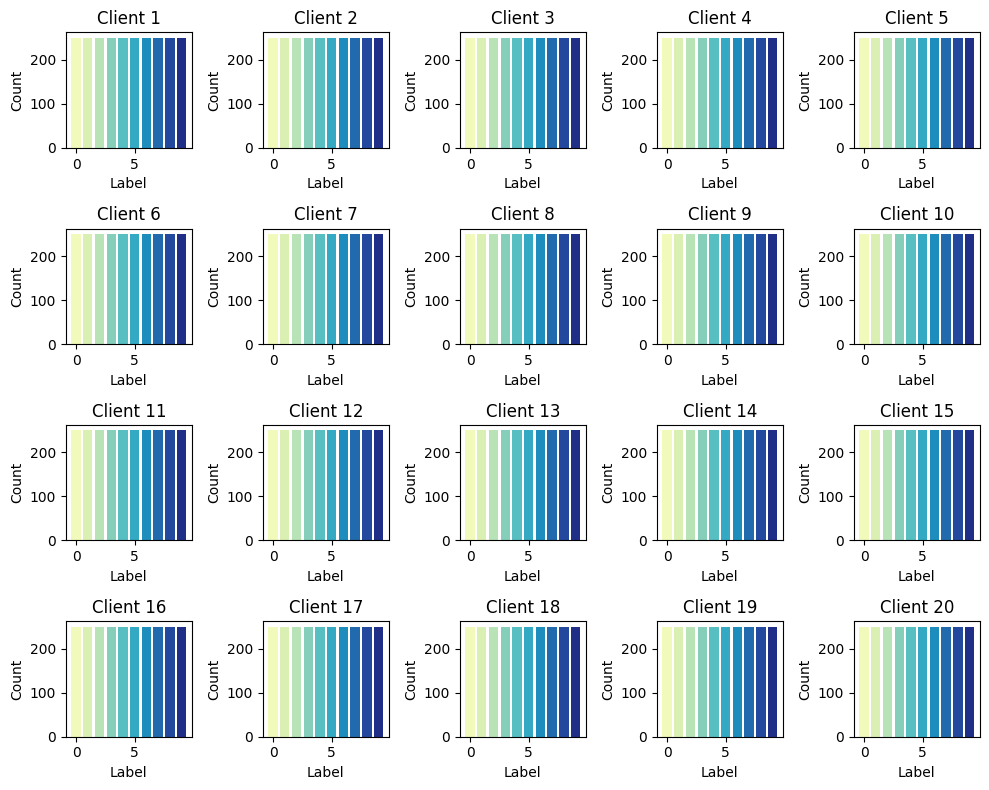

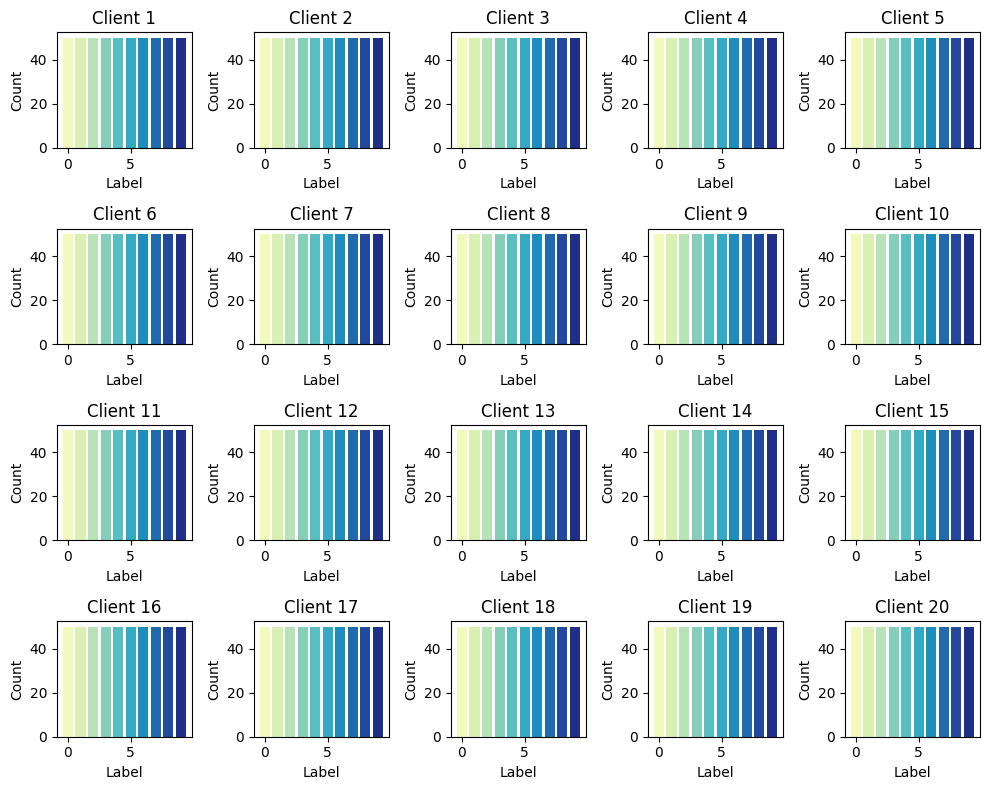

In [ ]:
CIFAR_10_train_iid_loaders, CIFAR_10_test_iid_loaders = split_dataset_balanced(NUM_CLIENTS, trainset, testset)

plot_label_distribution(CIFAR_10_train_iid_loaders)
plot_label_distribution(CIFAR_10_test_iid_loaders)

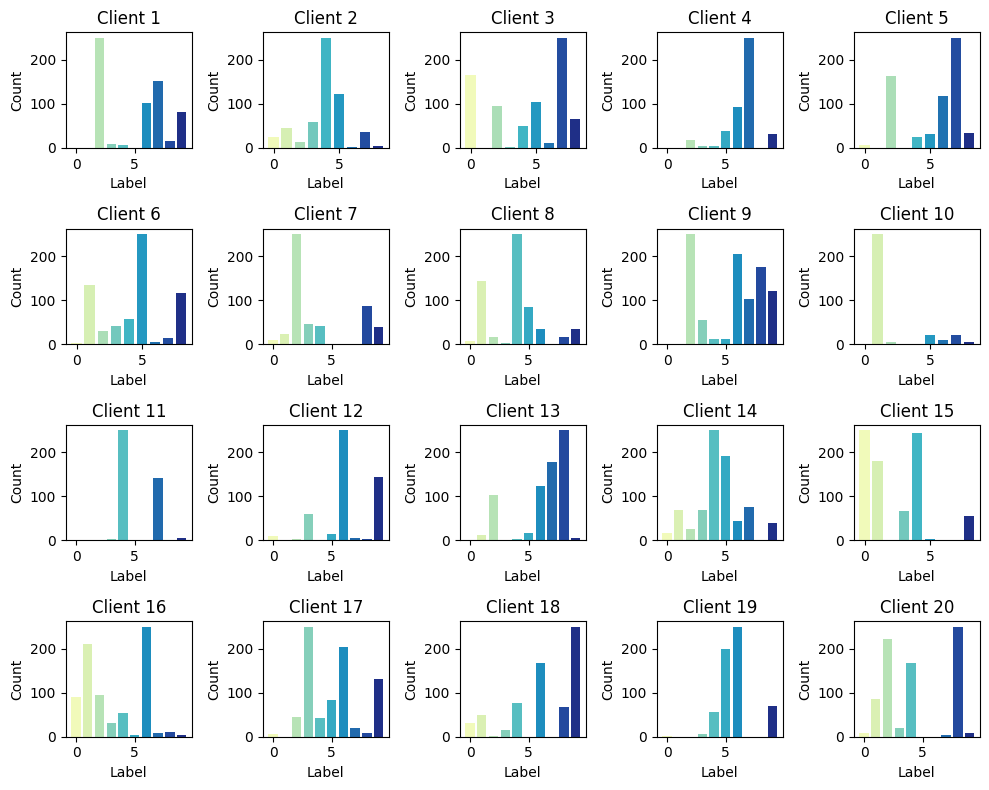

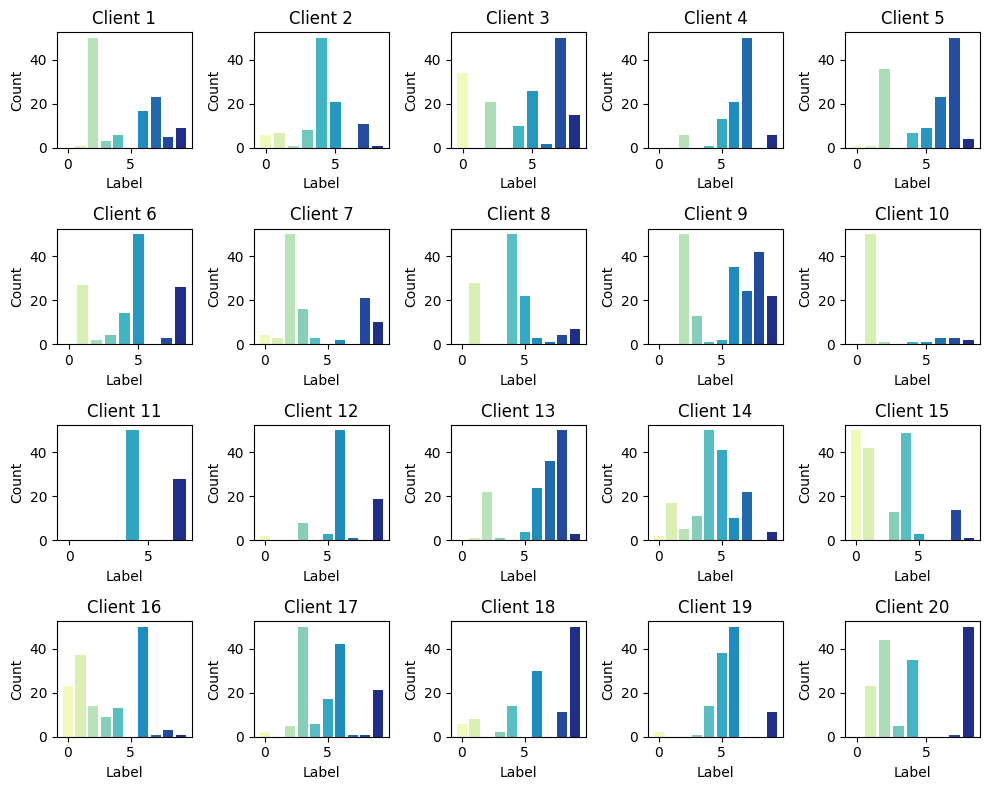

In [ ]:
CIFAR_10_train_non_iid_loaders, CIFAR_10_test_non_iid_loaders = create_unbalanced_loaders(CIFAR_10_train_iid_loaders, CIFAR_10_test_iid_loaders, 10, alpha=0.3)

plot_label_distribution(CIFAR_10_train_non_iid_loaders)
plot_label_distribution(CIFAR_10_test_non_iid_loaders)

### CIFAR 10 - Method A - iid data

INFO :      Starting Flower simulation, config: num_rounds=30, no round_timeout
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-07-17 07:32:56,433	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'memory': 8017777460.0, 'object_store_memory': 4008888729.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      No `client_resources` specified. Using minimal resources for clients.
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO :      [INIT]
INFO :      Requesting initial parame

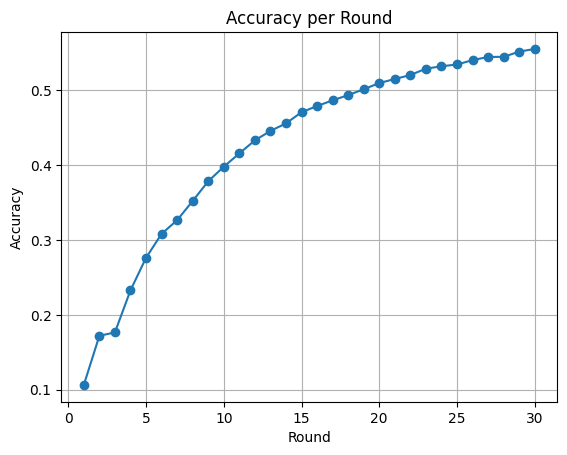

Classification Accuracy Matrix:
    Client 1  Client 2  Client 3  Client 4  Client 5  Client 6  Client 7  \
1      0.108     0.110     0.100     0.104     0.100     0.104     0.104   
2      0.186     0.164     0.162     0.172     0.162     0.176     0.162   
3      0.182     0.164     0.186     0.176     0.192     0.168     0.186   
4      0.220     0.242     0.256     0.252     0.226     0.210     0.226   
5      0.296     0.284     0.286     0.234     0.274     0.272     0.266   
6      0.312     0.298     0.328     0.306     0.290     0.344     0.326   
7      0.304     0.336     0.340     0.340     0.316     0.346     0.322   
8      0.364     0.376     0.354     0.328     0.350     0.356     0.320   
9      0.370     0.396     0.378     0.366     0.400     0.358     0.368   
10     0.418     0.396     0.428     0.378     0.392     0.372     0.396   
11     0.432     0.442     0.390     0.422     0.420     0.406     0.412   
12     0.428     0.448     0.418     0.412     0.444    

In [ ]:
CIFAR_10_iid_strategy_A = MethodA(evaluate_fn=get_evaluate_server_fn(Net().to(DEVICE), testloader))

start_simulation(CIFAR_10_train_iid_loaders, CIFAR_10_test_iid_loaders, CIFAR_10_iid_strategy_A)
CIFAR_10_iid_strategy_A.save_accuracy_matrix(f'/content/drive/MyDrive/Colab Notebooks/graduation project/Week5/cifar10/iid_strategy_A_accuracy_matrix_clients={NUM_CLIENTS}_round={ROUND}.csv')

### CIFAR 10 - Method A - non iid data

INFO :      Starting Flower simulation, config: num_rounds=30, no round_timeout
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-07-17 09:23:21,562	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0, 'object_store_memory': 4015248998.0, 'memory': 8030497998.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      No `client_resources` specified. Using minimal resources for clients.
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO :      [INIT]
INFO :      Requesting initial parame

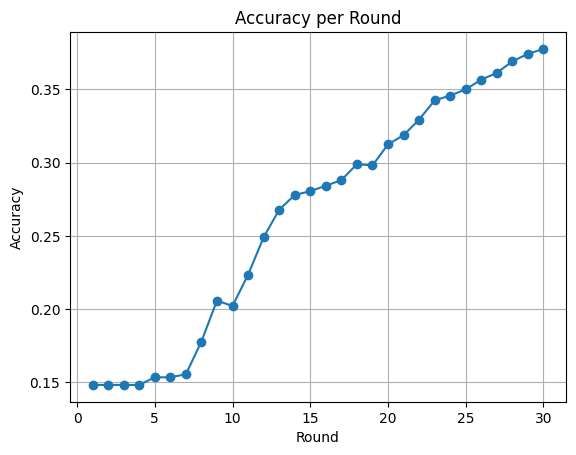

Classification Accuracy Matrix:
    Client 1  Client 2  Client 3  Client 4  Client 5  Client 6  Client 7  \
1   0.175573  0.216495  0.012658  0.000000  0.026087  0.602410  0.000000   
2   0.247934  0.170213  0.049180  0.149123  0.185185  0.012658  0.000000   
3   0.185185  0.170213  0.000000  0.149123  0.061728  0.000000  0.247934   
4   0.049180  0.175573  0.018349  0.000000  0.185185  0.289655  0.602410   
5   0.641026  0.120690  0.041379  0.052632  0.308642  0.053435  0.063291   
6   0.308642  0.476190  0.434783  0.111111  0.221519  0.016393  0.120690   
7   0.020619  0.027523  0.016393  0.028369  0.273256  0.419048  0.026455   
8   0.068966  0.190083  0.000000  0.182540  0.091743  0.016393  0.010309   
9   0.151724  0.158940  0.265432  0.361905  0.141844  0.204819  0.061856   
10  0.290123  0.119266  0.155172  0.049180  0.153439  0.075862  0.313953   
11  0.134752  0.099237  0.341772  0.125828  0.296512  0.156627  0.096491   
12  0.224138  0.206349  0.137615  0.192053  0.259259  0.

In [ ]:
CIFAR_10_non_iid_strategy_A = MethodA(evaluate_fn=get_evaluate_server_fn(Net().to(DEVICE), testloader))

start_simulation(CIFAR_10_train_non_iid_loaders, CIFAR_10_test_non_iid_loaders, CIFAR_10_non_iid_strategy_A)
CIFAR_10_non_iid_strategy_A.save_accuracy_matrix(f'/content/drive/MyDrive/Colab Notebooks/graduation project/Week5/cifar10/non_iid_strategy_A_accuracy_matrix_clients={NUM_CLIENTS}_round={ROUND}.csv')

### CIFAR 10 - Method B - iid data

INFO :      Starting Flower simulation, config: num_rounds=30, no round_timeout
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-07-17 10:25:34,304	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'object_store_memory': 4014849638.0, 'memory': 8029699278.0, 'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      No `client_resources` specified. Using minimal resources for clients.
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO :      [INIT]
INFO :      Requesting initial parame

Serial number of the client selected to fit: ['11', '7', '17', '19', '2', '12', '15', '13', '1', '14']


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (1, 720.3997337818146, {'accuracy': 0.1}, 88.82384657900002)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Serial number of the client selected to evaluate: ['11', '7', '17', '19', '2', '12', '15', '13', '1', '14']


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 15 clients (out of 20)


Serial number of the client selected to fit: ['1', '2', '3', '6', '7', '8', '9', '11', '12', '14', '15', '16', '17', '18', '19']


INFO :      aggregate_fit: received 15 results and 0 failures
INFO :      fit progress: (2, 719.2415554523468, {'accuracy': 0.1091}, 242.03521616200123)
INFO :      configure_evaluate: strategy sampled 15 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '2', '3', '6', '7', '8', '9', '11', '12', '14', '15', '16', '17', '18', '19']


INFO :      aggregate_evaluate: received 15 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 13 clients (out of 20)


Serial number of the client selected to fit: ['1', '2', '3', '4', '5', '6', '7', '10', '11', '12', '15', '16', '17']


INFO :      aggregate_fit: received 13 results and 0 failures
INFO :      fit progress: (3, 716.0714082717896, {'accuracy': 0.2111}, 391.341067976)
INFO :      configure_evaluate: strategy sampled 13 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '2', '3', '4', '5', '6', '7', '10', '11', '12', '15', '16', '17']


INFO :      aggregate_evaluate: received 13 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 7 clients (out of 20)


Serial number of the client selected to fit: ['2', '3', '4', '5', '7', '13', '15']


INFO :      aggregate_fit: received 7 results and 0 failures
INFO :      fit progress: (4, 698.4602658748627, {'accuracy': 0.1979}, 483.19573672800107)
INFO :      configure_evaluate: strategy sampled 7 clients (out of 20)


Serial number of the client selected to evaluate: ['2', '3', '4', '5', '7', '13', '15']


INFO :      aggregate_evaluate: received 7 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 12 clients (out of 20)


Serial number of the client selected to fit: ['0', '1', '2', '3', '4', '7', '8', '10', '13', '15', '17', '18']


INFO :      aggregate_fit: received 12 results and 0 failures
INFO :      fit progress: (5, 647.8359384536743, {'accuracy': 0.26}, 629.7045410570008)
INFO :      configure_evaluate: strategy sampled 12 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '1', '2', '3', '4', '7', '8', '10', '13', '15', '17', '18']


INFO :      aggregate_evaluate: received 12 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 12 clients (out of 20)


Serial number of the client selected to fit: ['0', '1', '3', '6', '7', '8', '10', '11', '12', '15', '17', '18']


INFO :      aggregate_fit: received 12 results and 0 failures
INFO :      fit progress: (6, 612.7354286909103, {'accuracy': 0.2923}, 758.2097936549999)
INFO :      configure_evaluate: strategy sampled 12 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '1', '3', '6', '7', '8', '10', '11', '12', '15', '17', '18']


INFO :      aggregate_evaluate: received 12 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 13 clients (out of 20)


Serial number of the client selected to fit: ['0', '1', '2', '3', '4', '5', '8', '11', '12', '13', '14', '16', '18']


INFO :      aggregate_fit: received 13 results and 0 failures
INFO :      fit progress: (7, 590.9145051240921, {'accuracy': 0.3187}, 954.5915480370004)
INFO :      configure_evaluate: strategy sampled 13 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '1', '2', '3', '4', '5', '8', '11', '12', '13', '14', '16', '18']


INFO :      aggregate_evaluate: received 13 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 13 clients (out of 20)


Serial number of the client selected to fit: ['3', '4', '5', '6', '7', '9', '11', '13', '14', '16', '17', '18', '19']


INFO :      aggregate_fit: received 13 results and 0 failures
INFO :      fit progress: (8, 566.9801502227783, {'accuracy': 0.3488}, 1117.8998906060006)
INFO :      configure_evaluate: strategy sampled 13 clients (out of 20)


Serial number of the client selected to evaluate: ['3', '4', '5', '6', '7', '9', '11', '13', '14', '16', '17', '18', '19']


INFO :      aggregate_evaluate: received 13 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 13 clients (out of 20)


Serial number of the client selected to fit: ['0', '1', '2', '5', '6', '8', '11', '12', '13', '15', '16', '17', '18']


INFO :      aggregate_fit: received 13 results and 0 failures
INFO :      fit progress: (9, 543.905279636383, {'accuracy': 0.3723}, 1265.845590926001)
INFO :      configure_evaluate: strategy sampled 13 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '1', '2', '5', '6', '8', '11', '12', '13', '15', '16', '17', '18']


INFO :      aggregate_evaluate: received 13 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 16 clients (out of 20)


Serial number of the client selected to fit: ['0', '2', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '15', '16', '17', '19']


INFO :      aggregate_fit: received 16 results and 0 failures
INFO :      fit progress: (10, 526.9458137750626, {'accuracy': 0.3873}, 1428.7239660020005)
INFO :      configure_evaluate: strategy sampled 16 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '2', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '15', '16', '17', '19']


INFO :      aggregate_evaluate: received 16 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


Serial number of the client selected to fit: ['1', '2', '3', '6', '8', '9', '10', '12', '15', '18']


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (11, 512.7525581121445, {'accuracy': 0.405}, 1553.395644944001)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '2', '3', '6', '8', '9', '10', '12', '15', '18']


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 11 clients (out of 20)


Serial number of the client selected to fit: ['3', '4', '7', '9', '10', '11', '12', '15', '17', '18', '19']


INFO :      aggregate_fit: received 11 results and 0 failures
INFO :      fit progress: (12, 500.19258522987366, {'accuracy': 0.4167}, 1670.749611018)
INFO :      configure_evaluate: strategy sampled 11 clients (out of 20)


Serial number of the client selected to evaluate: ['3', '4', '7', '9', '10', '11', '12', '15', '17', '18', '19']


INFO :      aggregate_evaluate: received 11 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


Serial number of the client selected to fit: ['2', '3', '5', '7', '10', '12', '14', '15']


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (13, 488.67755651474, {'accuracy': 0.4271}, 1767.8741945599995)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)


Serial number of the client selected to evaluate: ['2', '3', '5', '7', '10', '12', '14', '15']


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


Serial number of the client selected to fit: ['2', '3', '5', '8', '9', '10', '12', '13', '15', '17']


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (14, 477.7365196943283, {'accuracy': 0.4437}, 1875.3589264320017)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Serial number of the client selected to evaluate: ['2', '3', '5', '8', '9', '10', '12', '13', '15', '17']


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 9 clients (out of 20)


Serial number of the client selected to fit: ['3', '5', '6', '7', '12', '14', '17', '18', '19']


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      fit progress: (15, 469.84991133213043, {'accuracy': 0.4539}, 1982.2519813400013)
INFO :      configure_evaluate: strategy sampled 9 clients (out of 20)


Serial number of the client selected to evaluate: ['3', '5', '6', '7', '12', '14', '17', '18', '19']


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


Serial number of the client selected to fit: ['0', '1', '2', '4', '6', '8', '12', '13', '14', '16']


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (16, 461.8987536430359, {'accuracy': 0.4566}, 2090.0770094849995)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '1', '2', '4', '6', '8', '12', '13', '14', '16']


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 13 clients (out of 20)


Serial number of the client selected to fit: ['1', '2', '3', '5', '6', '8', '10', '11', '13', '15', '16', '17', '19']


INFO :      aggregate_fit: received 13 results and 0 failures
INFO :      fit progress: (17, 455.78668570518494, {'accuracy': 0.4663}, 2231.2235985140014)
INFO :      configure_evaluate: strategy sampled 13 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '2', '3', '5', '6', '8', '10', '11', '13', '15', '16', '17', '19']


INFO :      aggregate_evaluate: received 13 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 6 clients (out of 20)


Serial number of the client selected to fit: ['1', '3', '4', '6', '8', '11']


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (18, 452.11268842220306, {'accuracy': 0.4746}, 2326.1425064630002)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '3', '4', '6', '8', '11']


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 11 clients (out of 20)


Serial number of the client selected to fit: ['0', '1', '2', '4', '6', '9', '11', '12', '13', '15', '19']


INFO :      aggregate_fit: received 11 results and 0 failures
INFO :      fit progress: (19, 443.7747642993927, {'accuracy': 0.4796}, 2448.2882092359996)
INFO :      configure_evaluate: strategy sampled 11 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '1', '2', '4', '6', '9', '11', '12', '13', '15', '19']


INFO :      aggregate_evaluate: received 11 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


Serial number of the client selected to fit: ['0', '2', '4', '6', '7', '8', '10', '15', '16', '18']


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (20, 440.6874222755432, {'accuracy': 0.487}, 2577.5523882159996)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '2', '4', '6', '7', '8', '10', '15', '16', '18']


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 11 clients (out of 20)


Serial number of the client selected to fit: ['0', '1', '3', '4', '5', '9', '10', '11', '13', '16', '18']


INFO :      aggregate_fit: received 11 results and 0 failures
INFO :      fit progress: (21, 433.5688235759735, {'accuracy': 0.4952}, 2701.9149058150015)
INFO :      configure_evaluate: strategy sampled 11 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '1', '3', '4', '5', '9', '10', '11', '13', '16', '18']


INFO :      aggregate_evaluate: received 11 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 7 clients (out of 20)


Serial number of the client selected to fit: ['0', '1', '4', '6', '10', '14', '17']


INFO :      aggregate_fit: received 7 results and 0 failures
INFO :      fit progress: (22, 431.70162934064865, {'accuracy': 0.5009}, 2797.960909995001)
INFO :      configure_evaluate: strategy sampled 7 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '1', '4', '6', '10', '14', '17']


INFO :      aggregate_evaluate: received 7 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 9 clients (out of 20)


Serial number of the client selected to fit: ['2', '3', '4', '7', '8', '9', '13', '17', '19']


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      fit progress: (23, 425.6692759990692, {'accuracy': 0.5071}, 2889.642856712)
INFO :      configure_evaluate: strategy sampled 9 clients (out of 20)


Serial number of the client selected to evaluate: ['2', '3', '4', '7', '8', '9', '13', '17', '19']


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


Serial number of the client selected to fit: ['1', '2', '4', '6', '7', '9', '11', '14', '18', '19']


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (24, 421.77612709999084, {'accuracy': 0.5106}, 3003.101191087999)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '2', '4', '6', '7', '9', '11', '14', '18', '19']


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


Serial number of the client selected to fit: ['2', '3', '4', '5', '7', '10', '12', '15', '16', '17']


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (25, 417.7889886498451, {'accuracy': 0.5181}, 3111.8405736779987)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Serial number of the client selected to evaluate: ['2', '3', '4', '5', '7', '10', '12', '15', '16', '17']


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 9 clients (out of 20)


Serial number of the client selected to fit: ['0', '6', '7', '9', '10', '11', '16', '18', '19']


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      fit progress: (26, 412.3296453356743, {'accuracy': 0.527}, 3215.6095795480014)
INFO :      configure_evaluate: strategy sampled 9 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '6', '7', '9', '10', '11', '16', '18', '19']


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


Serial number of the client selected to fit: ['1', '2', '5', '7', '8', '11', '13', '14']


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (27, 412.3660011291504, {'accuracy': 0.5228}, 3308.268937319999)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '2', '5', '7', '8', '11', '13', '14']


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 15 clients (out of 20)


Serial number of the client selected to fit: ['1', '2', '3', '5', '6', '8', '9', '10', '12', '14', '15', '16', '17', '18', '19']


INFO :      aggregate_fit: received 15 results and 0 failures
INFO :      fit progress: (28, 405.8791976571083, {'accuracy': 0.5362}, 3456.2579321440007)
INFO :      configure_evaluate: strategy sampled 15 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '2', '3', '5', '6', '8', '9', '10', '12', '14', '15', '16', '17', '18', '19']


INFO :      aggregate_evaluate: received 15 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 11 clients (out of 20)


Serial number of the client selected to fit: ['0', '1', '2', '3', '4', '5', '6', '12', '14', '16', '17']


INFO :      aggregate_fit: received 11 results and 0 failures
INFO :      fit progress: (29, 403.51222479343414, {'accuracy': 0.542}, 3586.3673461060007)
INFO :      configure_evaluate: strategy sampled 11 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '1', '2', '3', '4', '5', '6', '12', '14', '16', '17']


INFO :      aggregate_evaluate: received 11 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


Serial number of the client selected to fit: ['2', '5', '7', '9', '12', '14', '15', '19']


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (30, 401.31581687927246, {'accuracy': 0.5464}, 3686.983247856)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)


Serial number of the client selected to evaluate: ['2', '5', '7', '9', '12', '14', '15', '19']


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 30 round(s) in 3705.35s
INFO :      	History (loss, distributed):
INFO :      		round 1: 36.82799038887024
INFO :      		round 2: 36.773717149098715
INFO :      		round 3: 36.623683562645546
INFO :      		round 4: 35.71069576059069
INFO :      		round 5: 33.25952189167341
INFO :      		round 6: 31.620576441287994
INFO :      		round 7: 30.301998312656696
INFO :      		round 8: 29.067721467751724
INFO :      		round 9: 27.929321967638455
INFO :      		round 10: 27.0485515370965
INFO :      		round 11: 26.377451264858244
INFO :      		round 12: 25.755713153969158
INFO :      		round 13: 25.166633769869804
INFO :      		round 14: 24.38697247505188
INFO :      		round 15: 24.232987178696526
INFO :      		round 16: 23.919302517175673
INFO :      		round 17: 23.152179007346813
INFO :      		round 18: 23.401050368944805
INFO :      		round 19: 22.85111738876863
INFO : 

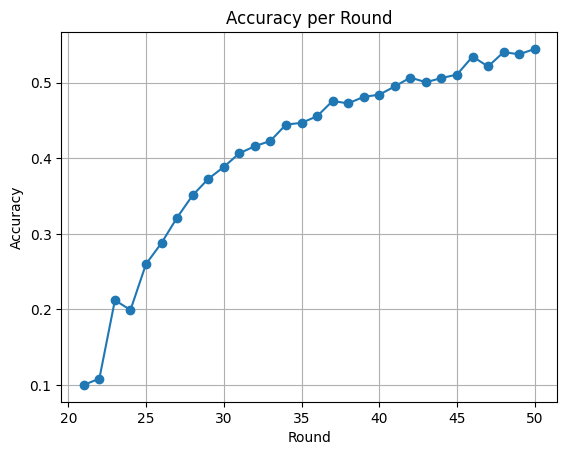

Classification Accuracy Matrix:
    Client 1  Client 2  Client 3  Client 4  Client 5  Client 6  Client 7  \
1        NaN     0.100     0.100       NaN       NaN       NaN       NaN   
2        NaN     0.114     0.110     0.102       NaN       NaN     0.108   
3        NaN     0.194     0.226     0.220     0.214     0.216     0.226   
4        NaN     0.194     0.242     0.186     0.194     0.230     0.226   
5      0.258     0.246     0.288     0.260     0.238     0.230     0.226   
6      0.308     0.284     0.288     0.302     0.238     0.230     0.284   
7      0.314     0.310     0.330     0.320     0.316     0.336     0.284   
8      0.314     0.310     0.330     0.334     0.338     0.370     0.338   
9      0.352     0.378     0.394     0.334     0.338     0.388     0.366   
10     0.386     0.378     0.386     0.334     0.378     0.388     0.392   
11     0.386     0.402     0.414     0.396     0.378     0.388     0.402   
12     0.386     0.402     0.414     0.416     0.392    

In [ ]:
CIFAR_10_iid_strategy_B = MethodB(0.5, NUM_CLIENTS, evaluate_fn=get_evaluate_server_fn(Net().to(DEVICE), testloader))

start_simulation(CIFAR_10_train_iid_loaders, CIFAR_10_test_iid_loaders, CIFAR_10_iid_strategy_B)
CIFAR_10_iid_strategy_B.save_accuracy_matrix(f'/content/drive/MyDrive/Colab Notebooks/graduation project/Week5/cifar10/iid_strategy_B_accuracy_matrix_clients={NUM_CLIENTS}_round={ROUND}.csv')
CIFAR_10_iid_strategy_B.probability_df.to_csv(f'/content/drive/MyDrive/Colab Notebooks/graduation project/Week5/cifar10/iid_strategy_B_probability_matrix_clients={NUM_CLIENTS}_round={ROUND}.csv')

### CIFAR 10 - Method B - non iid data

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
INFO :      Starting Flower simulation, config: num_rounds=30, no round_timeout
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-07-17 11:27:51,964	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'object_store_memory': 4014425702.0, 'memory': 8028851406.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'CPU': 2.0}
INFO :      Optimize your simulation with Flower VCE: https://flow

Serial number of the client selected to fit: ['17', '6', '16', '8', '3', '0', '2', '4', '14', '9']


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (1, 721.0619986057281, {'accuracy': 0.1095}, 45.22851812000226)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Serial number of the client selected to evaluate: ['17', '6', '16', '8', '3', '0', '2', '4', '14', '9']


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 16 clients (out of 20)


Serial number of the client selected to fit: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '14', '16', '17', '19']


INFO :      aggregate_fit: received 16 results and 0 failures
INFO :      fit progress: (2, 721.1085727214813, {'accuracy': 0.0986}, 134.0072470720006)
INFO :      configure_evaluate: strategy sampled 16 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '14', '16', '17', '19']


INFO :      aggregate_evaluate: received 16 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 17 clients (out of 20)


Serial number of the client selected to fit: ['0', '2', '3', '4', '5', '6', '8', '9', '10', '11', '12', '13', '14', '16', '17', '18', '19']


INFO :      aggregate_fit: received 17 results and 0 failures
INFO :      fit progress: (3, 722.5131540298462, {'accuracy': 0.1003}, 233.30940990100135)
INFO :      configure_evaluate: strategy sampled 17 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '2', '3', '4', '5', '6', '8', '9', '10', '11', '12', '13', '14', '16', '17', '18', '19']


INFO :      aggregate_evaluate: received 17 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 14 clients (out of 20)


Serial number of the client selected to fit: ['2', '3', '4', '5', '6', '8', '9', '10', '12', '13', '14', '16', '17', '19']


INFO :      aggregate_fit: received 14 results and 0 failures
INFO :      fit progress: (4, 735.2482628822327, {'accuracy': 0.105}, 327.1785517520002)
INFO :      configure_evaluate: strategy sampled 14 clients (out of 20)


Serial number of the client selected to evaluate: ['2', '3', '4', '5', '6', '8', '9', '10', '12', '13', '14', '16', '17', '19']


INFO :      aggregate_evaluate: received 14 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 17 clients (out of 20)


Serial number of the client selected to fit: ['2', '3', '4', '5', '6', '7', '8', '9', '10', '12', '13', '14', '15', '16', '17', '18', '19']


INFO :      aggregate_fit: received 17 results and 0 failures
INFO :      fit progress: (5, 737.4153592586517, {'accuracy': 0.1}, 424.13906994699937)
INFO :      configure_evaluate: strategy sampled 17 clients (out of 20)


Serial number of the client selected to evaluate: ['2', '3', '4', '5', '6', '7', '8', '9', '10', '12', '13', '14', '15', '16', '17', '18', '19']


INFO :      aggregate_evaluate: received 17 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 14 clients (out of 20)


Serial number of the client selected to fit: ['0', '2', '3', '4', '5', '6', '8', '9', '12', '15', '16', '17', '18', '19']


INFO :      aggregate_fit: received 14 results and 0 failures
INFO :      fit progress: (6, 748.4778213500977, {'accuracy': 0.1121}, 519.4139015450019)
INFO :      configure_evaluate: strategy sampled 14 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '2', '3', '4', '5', '6', '8', '9', '12', '15', '16', '17', '18', '19']


INFO :      aggregate_evaluate: received 14 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 12 clients (out of 20)


Serial number of the client selected to fit: ['1', '4', '5', '6', '7', '9', '11', '13', '14', '16', '18', '19']


INFO :      aggregate_fit: received 12 results and 0 failures
INFO :      fit progress: (7, 756.3282887935638, {'accuracy': 0.1}, 601.5075911150016)
INFO :      configure_evaluate: strategy sampled 12 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '4', '5', '6', '7', '9', '11', '13', '14', '16', '18', '19']


INFO :      aggregate_evaluate: received 12 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 16 clients (out of 20)


Serial number of the client selected to fit: ['0', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '15', '16', '18', '19']


INFO :      aggregate_fit: received 16 results and 0 failures
INFO :      fit progress: (8, 739.6260344982147, {'accuracy': 0.1322}, 687.1064964040015)
INFO :      configure_evaluate: strategy sampled 16 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '15', '16', '18', '19']


INFO :      aggregate_evaluate: received 16 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 12 clients (out of 20)


Serial number of the client selected to fit: ['1', '2', '3', '5', '7', '8', '9', '10', '11', '14', '15', '19']


INFO :      aggregate_fit: received 12 results and 0 failures
INFO :      fit progress: (9, 726.2686821222305, {'accuracy': 0.1209}, 775.5888930420006)
INFO :      configure_evaluate: strategy sampled 12 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '2', '3', '5', '7', '8', '9', '10', '11', '14', '15', '19']


INFO :      aggregate_evaluate: received 12 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 12 clients (out of 20)


Serial number of the client selected to fit: ['1', '2', '3', '5', '6', '7', '8', '9', '11', '13', '15', '17']


INFO :      aggregate_fit: received 12 results and 0 failures
INFO :      fit progress: (10, 686.1189961433411, {'accuracy': 0.1567}, 848.7176484640004)
INFO :      configure_evaluate: strategy sampled 12 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '2', '3', '5', '6', '7', '8', '9', '11', '13', '15', '17']


INFO :      aggregate_evaluate: received 12 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 12 clients (out of 20)


Serial number of the client selected to fit: ['0', '1', '2', '5', '6', '7', '12', '13', '16', '17', '18', '19']


INFO :      aggregate_fit: received 12 results and 0 failures
INFO :      fit progress: (11, 709.491263628006, {'accuracy': 0.146}, 925.7568989140018)
INFO :      configure_evaluate: strategy sampled 12 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '1', '2', '5', '6', '7', '12', '13', '16', '17', '18', '19']


INFO :      aggregate_evaluate: received 12 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 15 clients (out of 20)


Serial number of the client selected to fit: ['0', '2', '3', '4', '5', '6', '7', '8', '12', '14', '15', '16', '17', '18', '19']


INFO :      aggregate_fit: received 15 results and 0 failures
INFO :      fit progress: (12, 694.9464019536972, {'accuracy': 0.1855}, 1012.8565275030014)
INFO :      configure_evaluate: strategy sampled 15 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '2', '3', '4', '5', '6', '7', '8', '12', '14', '15', '16', '17', '18', '19']


INFO :      aggregate_evaluate: received 15 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


Serial number of the client selected to fit: ['0', '2', '5', '6', '7', '10', '12', '14', '16', '19']


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (13, 721.6557619571686, {'accuracy': 0.1582}, 1088.5805337210004)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '2', '5', '6', '7', '10', '12', '14', '16', '19']


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 14 clients (out of 20)


Serial number of the client selected to fit: ['0', '1', '5', '6', '7', '8', '9', '11', '12', '13', '14', '16', '17', '18']


INFO :      aggregate_fit: received 14 results and 0 failures
INFO :      fit progress: (14, 671.6587467193604, {'accuracy': 0.2053}, 1167.623580888001)
INFO :      configure_evaluate: strategy sampled 14 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '1', '5', '6', '7', '8', '9', '11', '12', '13', '14', '16', '17', '18']


INFO :      aggregate_evaluate: received 14 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


Serial number of the client selected to fit: ['1', '2', '3', '4', '7', '8', '13', '14', '17', '18']


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (15, 675.5052013397217, {'accuracy': 0.1871}, 1243.2387008670012)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '2', '3', '4', '7', '8', '13', '14', '17', '18']


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


Serial number of the client selected to fit: ['1', '2', '3', '4', '5', '10', '13', '14', '17', '19']


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (16, 697.3378670215607, {'accuracy': 0.1696}, 1306.7776593410017)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '2', '3', '4', '5', '10', '13', '14', '17', '19']


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 16 clients (out of 20)


Serial number of the client selected to fit: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '11', '13', '15', '16', '17', '19']


INFO :      aggregate_fit: received 16 results and 0 failures
INFO :      fit progress: (17, 634.9863905906677, {'accuracy': 0.2388}, 1395.0605433839992)
INFO :      configure_evaluate: strategy sampled 16 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '11', '13', '15', '16', '17', '19']


INFO :      aggregate_evaluate: received 16 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 12 clients (out of 20)


Serial number of the client selected to fit: ['1', '3', '4', '5', '6', '7', '8', '9', '10', '13', '14', '19']


INFO :      aggregate_fit: received 12 results and 0 failures
INFO :      fit progress: (18, 670.8778077363968, {'accuracy': 0.2063}, 1478.7048896939996)
INFO :      configure_evaluate: strategy sampled 12 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '3', '4', '5', '6', '7', '8', '9', '10', '13', '14', '19']


INFO :      aggregate_evaluate: received 12 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 11 clients (out of 20)


Serial number of the client selected to fit: ['1', '3', '4', '5', '6', '8', '11', '12', '15', '17', '19']


INFO :      aggregate_fit: received 11 results and 0 failures
INFO :      fit progress: (19, 644.2413450479507, {'accuracy': 0.2222}, 1550.6078656200007)
INFO :      configure_evaluate: strategy sampled 11 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '3', '4', '5', '6', '8', '11', '12', '15', '17', '19']


INFO :      aggregate_evaluate: received 11 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 9 clients (out of 20)


Serial number of the client selected to fit: ['1', '5', '7', '8', '10', '11', '13', '17', '19']


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      fit progress: (20, 667.7648231983185, {'accuracy': 0.1987}, 1615.0477023610001)
INFO :      configure_evaluate: strategy sampled 9 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '5', '7', '8', '10', '11', '13', '17', '19']


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 14 clients (out of 20)


Serial number of the client selected to fit: ['0', '1', '3', '4', '5', '7', '8', '11', '12', '13', '15', '16', '17', '18']


INFO :      aggregate_fit: received 14 results and 0 failures
INFO :      fit progress: (21, 645.495964050293, {'accuracy': 0.2402}, 1691.2846641690012)
INFO :      configure_evaluate: strategy sampled 14 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '1', '3', '4', '5', '7', '8', '11', '12', '13', '15', '16', '17', '18']


INFO :      aggregate_evaluate: received 14 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


Serial number of the client selected to fit: ['2', '4', '5', '6', '7', '9', '13', '15']


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (22, 644.1181004047394, {'accuracy': 0.2556}, 1755.6926028929993)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)


Serial number of the client selected to evaluate: ['2', '4', '5', '6', '7', '9', '13', '15']


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 9 clients (out of 20)


Serial number of the client selected to fit: ['2', '3', '4', '6', '11', '12', '14', '15', '19']


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      fit progress: (23, 625.3968703746796, {'accuracy': 0.2418}, 1814.6545713359992)
INFO :      configure_evaluate: strategy sampled 9 clients (out of 20)


Serial number of the client selected to evaluate: ['2', '3', '4', '6', '11', '12', '14', '15', '19']


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 14 clients (out of 20)


Serial number of the client selected to fit: ['2', '3', '6', '7', '9', '10', '11', '13', '14', '15', '16', '17', '18', '19']


INFO :      aggregate_fit: received 14 results and 0 failures
INFO :      fit progress: (24, 605.8614432811737, {'accuracy': 0.2818}, 1889.7450920800002)
INFO :      configure_evaluate: strategy sampled 14 clients (out of 20)


Serial number of the client selected to evaluate: ['2', '3', '6', '7', '9', '10', '11', '13', '14', '15', '16', '17', '18', '19']


INFO :      aggregate_evaluate: received 14 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 11 clients (out of 20)


Serial number of the client selected to fit: ['3', '4', '5', '6', '8', '10', '11', '14', '15', '16', '19']


INFO :      aggregate_fit: received 11 results and 0 failures
INFO :      fit progress: (25, 608.8081511259079, {'accuracy': 0.2738}, 1967.1070319460014)
INFO :      configure_evaluate: strategy sampled 11 clients (out of 20)


Serial number of the client selected to evaluate: ['3', '4', '5', '6', '8', '10', '11', '14', '15', '16', '19']


INFO :      aggregate_evaluate: received 11 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 12 clients (out of 20)


Serial number of the client selected to fit: ['2', '3', '4', '6', '10', '11', '12', '14', '15', '16', '17', '18']


INFO :      aggregate_fit: received 12 results and 0 failures
INFO :      fit progress: (26, 603.53449177742, {'accuracy': 0.2933}, 2039.6582631810015)
INFO :      configure_evaluate: strategy sampled 12 clients (out of 20)


Serial number of the client selected to evaluate: ['2', '3', '4', '6', '10', '11', '12', '14', '15', '16', '17', '18']


INFO :      aggregate_evaluate: received 12 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 11 clients (out of 20)


Serial number of the client selected to fit: ['0', '2', '3', '4', '7', '10', '12', '14', '16', '17', '19']


INFO :      aggregate_fit: received 11 results and 0 failures
INFO :      fit progress: (27, 613.2214500904083, {'accuracy': 0.2842}, 2111.4301720090007)
INFO :      configure_evaluate: strategy sampled 11 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '2', '3', '4', '7', '10', '12', '14', '16', '17', '19']


INFO :      aggregate_evaluate: received 11 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 9 clients (out of 20)


Serial number of the client selected to fit: ['0', '2', '4', '7', '10', '11', '13', '15', '19']


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      fit progress: (28, 603.5981121063232, {'accuracy': 0.305}, 2172.500291122)
INFO :      configure_evaluate: strategy sampled 9 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '2', '4', '7', '10', '11', '13', '15', '19']


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 12 clients (out of 20)


Serial number of the client selected to fit: ['0', '1', '2', '7', '8', '11', '12', '13', '14', '15', '16', '18']


INFO :      aggregate_fit: received 12 results and 0 failures
INFO :      fit progress: (29, 572.921637058258, {'accuracy': 0.3232}, 2242.882464442002)
INFO :      configure_evaluate: strategy sampled 12 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '1', '2', '7', '8', '11', '12', '13', '14', '15', '16', '18']


INFO :      aggregate_evaluate: received 12 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


Serial number of the client selected to fit: ['0', '3', '4', '6', '7', '9', '11', '15', '16', '19']


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (30, 588.2619696855545, {'accuracy': 0.2962}, 2311.6229265389993)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '3', '4', '6', '7', '9', '11', '15', '16', '19']


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 30 round(s) in 2334.18s
INFO :      	History (loss, distributed):
INFO :      		round 1: 10.328147602081298
INFO :      		round 2: 9.72557881474495
INFO :      		round 3: 9.995494604110718
INFO :      		round 4: 10.277607457978386
INFO :      		round 5: 10.063237898490009
INFO :      		round 6: 9.643539428710938
INFO :      		round 7: 9.551506102085114
INFO :      		round 8: 9.056820221245289
INFO :      		round 9: 9.105863312880198
INFO :      		round 10: 8.936331629753113
INFO :      		round 11: 9.467169324556986
INFO :      		round 12: 9.66205723285675
INFO :      		round 13: 9.338309776782989
INFO :      		round 14: 8.759906266416822
INFO :      		round 15: 9.317073619365692
INFO :      		round 16: 8.871800243854523
INFO :      		round 17: 8.411100871860981
INFO :      		round 18: 8.199579993883768
INFO :      		round 19: 8.291375041007996
INFO :      		rou

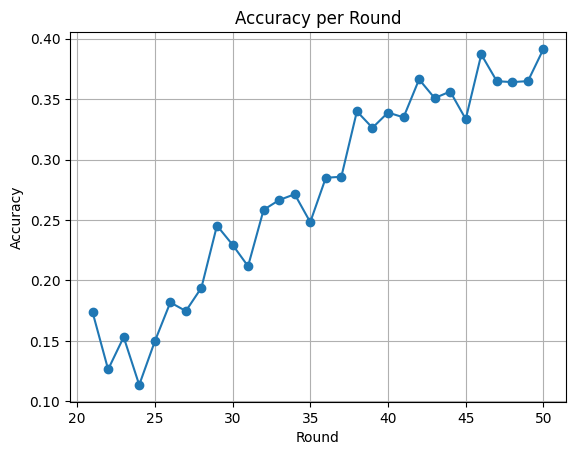

Classification Accuracy Matrix:
    Client 1  Client 2  Client 3  Client 4  Client 5  Client 6  Client 7  \
1   0.192982       NaN  0.291139  0.474227  0.335878       NaN  0.009174   
2   0.236842  0.066667  0.278481  0.453608  0.351145  0.023810  0.000000   
3   0.149123  0.066667  0.018987  0.216495  0.175573  0.000000  0.018349   
4   0.149123  0.066667  0.031646  0.206186  0.244275  0.007937  0.036697   
5   0.149123  0.066667  0.063291  0.010309  0.053435  0.111111  0.027523   
6   0.201754  0.066667  0.025316  0.216495  0.206107  0.007937  0.064220   
7   0.201754  0.476190  0.025316  0.216495  0.053435  0.111111  0.027523   
8   0.219298  0.476190  0.063291  0.226804  0.267176  0.015873  0.091743   
9   0.219298  0.457143  0.063291  0.010309  0.267176  0.174603  0.091743   
10  0.219298  0.057143  0.018987  0.185567  0.267176  0.126984  0.082569   
11  0.070175  0.428571  0.101266  0.185567  0.267176  0.206349  0.128440   
12  0.307018  0.428571  0.120253  0.195876  0.312977  0.

In [ ]:
CIFAR_10_non_iid_strategy_B = MethodB(0.5, NUM_CLIENTS, evaluate_fn=get_evaluate_server_fn(Net().to(DEVICE), testloader))

start_simulation(CIFAR_10_train_non_iid_loaders, CIFAR_10_test_non_iid_loaders, CIFAR_10_non_iid_strategy_B)
CIFAR_10_non_iid_strategy_B.save_accuracy_matrix(f'/content/drive/MyDrive/Colab Notebooks/graduation project/Week5/cifar10/non_iid_strategy_B_accuracy_matrix_clients={NUM_CLIENTS}_round={ROUND}.csv')
CIFAR_10_non_iid_strategy_B.probability_df.to_csv(f'/content/drive/MyDrive/Colab Notebooks/graduation project/Week5/cifar10/non_iid_strategy_B_probability_matrix_clients={NUM_CLIENTS}_round={ROUND}.csv')

### CIFAR 10 - Method C - iid data

INFO :      Starting Flower simulation, config: num_rounds=30, no round_timeout
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-07-17 13:29:23,022	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0, 'object_store_memory': 4009116057.0, 'memory': 8018232116.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      No `client_resources` specified. Using minimal resources for clients.
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO :      [INIT]
INFO :      Requesting initial parame

server_round: 1
Serial number of the client selected to fit: ['17', '7', '15', '18', '6', '12', '3', '1', '9', '11']


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (1, 720.0910360813141, {'accuracy': 0.1261}, 93.95206845999928)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Serial number of the client selected to evaluate: ['17', '7', '15', '18', '6', '12', '3', '1', '9', '11']


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 14 clients (out of 20)


server_round: 2
server_round: 2
Serial number of the client selected to fit: ['1', '3', '4', '6', '7', '8', '9', '10', '11', '12', '15', '16', '17', '18']


INFO :      aggregate_fit: received 14 results and 0 failures
INFO :      fit progress: (2, 717.5830321311951, {'accuracy': 0.1358}, 239.0981202719995)
INFO :      configure_evaluate: strategy sampled 14 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '3', '4', '6', '7', '8', '9', '10', '11', '12', '15', '16', '17', '18']


INFO :      aggregate_evaluate: received 14 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 14 clients (out of 20)


server_round: 3
server_round: 3
Serial number of the client selected to fit: ['1', '3', '4', '6', '7', '8', '9', '11', '12', '13', '14', '16', '17', '19']


INFO :      aggregate_fit: received 14 results and 0 failures
INFO :      fit progress: (3, 706.5374863147736, {'accuracy': 0.186}, 390.3216476660018)
INFO :      configure_evaluate: strategy sampled 14 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '3', '4', '6', '7', '8', '9', '11', '12', '13', '14', '16', '17', '19']


INFO :      aggregate_evaluate: received 14 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 15 clients (out of 20)


server_round: 4
server_round: 4
Serial number of the client selected to fit: ['1', '3', '4', '5', '6', '8', '9', '10', '11', '12', '13', '14', '16', '18', '19']


INFO :      aggregate_fit: received 15 results and 0 failures
INFO :      fit progress: (4, 656.6786795854568, {'accuracy': 0.2606}, 551.0354702760014)
INFO :      configure_evaluate: strategy sampled 15 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '3', '4', '5', '6', '8', '9', '10', '11', '12', '13', '14', '16', '18', '19']


INFO :      aggregate_evaluate: received 15 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 13 clients (out of 20)


server_round: 5
server_round: 5
Serial number of the client selected to fit: ['0', '1', '3', '4', '5', '6', '7', '12', '13', '14', '15', '18', '19']


INFO :      aggregate_fit: received 13 results and 0 failures
INFO :      fit progress: (5, 613.4201823472977, {'accuracy': 0.2986}, 696.4892914990014)
INFO :      configure_evaluate: strategy sampled 13 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '1', '3', '4', '5', '6', '7', '12', '13', '14', '15', '18', '19']


INFO :      aggregate_evaluate: received 13 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 17 clients (out of 20)


server_round: 6
server_round: 6
Serial number of the client selected to fit: ['1', '3', '4', '5', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19']


INFO :      aggregate_fit: received 17 results and 0 failures
INFO :      fit progress: (6, 588.5744290351868, {'accuracy': 0.3194}, 876.0019160590018)
INFO :      configure_evaluate: strategy sampled 17 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '3', '4', '5', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19']


INFO :      aggregate_evaluate: received 17 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 17 clients (out of 20)


server_round: 7
server_round: 7
Serial number of the client selected to fit: ['0', '1', '2', '4', '6', '7', '8', '9', '11', '12', '13', '14', '15', '16', '17', '18', '19']


INFO :      aggregate_fit: received 17 results and 0 failures
INFO :      fit progress: (7, 565.8105057477951, {'accuracy': 0.3461}, 1056.1806696579988)
INFO :      configure_evaluate: strategy sampled 17 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '1', '2', '4', '6', '7', '8', '9', '11', '12', '13', '14', '15', '16', '17', '18', '19']


INFO :      aggregate_evaluate: received 17 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 12 clients (out of 20)


server_round: 8
server_round: 8
Serial number of the client selected to fit: ['0', '1', '3', '5', '6', '10', '11', '12', '13', '14', '15', '19']


INFO :      aggregate_fit: received 12 results and 0 failures
INFO :      fit progress: (8, 542.1045477390289, {'accuracy': 0.3725}, 1205.2045998089998)
INFO :      configure_evaluate: strategy sampled 12 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '1', '3', '5', '6', '10', '11', '12', '13', '14', '15', '19']


INFO :      aggregate_evaluate: received 12 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 11 clients (out of 20)


server_round: 9
server_round: 9
Serial number of the client selected to fit: ['0', '2', '4', '5', '7', '9', '10', '11', '13', '15', '16']


INFO :      aggregate_fit: received 11 results and 0 failures
INFO :      fit progress: (9, 524.2578150033951, {'accuracy': 0.3868}, 1327.2187823610002)
INFO :      configure_evaluate: strategy sampled 11 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '2', '4', '5', '7', '9', '10', '11', '13', '15', '16']


INFO :      aggregate_evaluate: received 11 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


server_round: 10
server_round: 10
Serial number of the client selected to fit: ['0', '1', '2', '4', '5', '13', '14', '15', '17', '19']


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (10, 507.9079450368881, {'accuracy': 0.4067}, 1445.6411090660004)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '1', '2', '4', '5', '13', '14', '15', '17', '19']


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


server_round: 11
server_round: 11
Serial number of the client selected to fit: ['0', '3', '5', '6', '8', '10', '12', '16', '18', '19']


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (11, 496.40611612796783, {'accuracy': 0.4219}, 1553.9334939889995)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '3', '5', '6', '8', '10', '12', '16', '18', '19']


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 12 clients (out of 20)


server_round: 12
server_round: 12
Serial number of the client selected to fit: ['1', '3', '4', '5', '6', '8', '10', '12', '13', '14', '17', '19']


INFO :      aggregate_fit: received 12 results and 0 failures
INFO :      fit progress: (12, 484.38216757774353, {'accuracy': 0.4361}, 1686.567458370002)
INFO :      configure_evaluate: strategy sampled 12 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '3', '4', '5', '6', '8', '10', '12', '13', '14', '17', '19']


INFO :      aggregate_evaluate: received 12 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 14 clients (out of 20)


server_round: 13
server_round: 13
Serial number of the client selected to fit: ['0', '2', '3', '4', '6', '9', '10', '11', '12', '13', '15', '16', '17', '19']


INFO :      aggregate_fit: received 14 results and 0 failures
INFO :      fit progress: (13, 474.03095269203186, {'accuracy': 0.4506}, 1833.806189490002)
INFO :      configure_evaluate: strategy sampled 14 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '2', '3', '4', '6', '9', '10', '11', '12', '13', '15', '16', '17', '19']


INFO :      aggregate_evaluate: received 14 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


server_round: 14
server_round: 14
Serial number of the client selected to fit: ['3', '5', '6', '9', '10', '11', '12', '13', '18', '19']


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (14, 465.19954013824463, {'accuracy': 0.4634}, 1956.4371230630022)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Serial number of the client selected to evaluate: ['3', '5', '6', '9', '10', '11', '12', '13', '18', '19']


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 7 clients (out of 20)


server_round: 15
server_round: 15
Serial number of the client selected to fit: ['1', '2', '3', '9', '11', '16', '18']


INFO :      aggregate_fit: received 7 results and 0 failures
INFO :      fit progress: (15, 457.29665875434875, {'accuracy': 0.4746}, 2043.0766249219996)
INFO :      configure_evaluate: strategy sampled 7 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '2', '3', '9', '11', '16', '18']


INFO :      aggregate_evaluate: received 7 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 6 clients (out of 20)


server_round: 16
server_round: 16
Serial number of the client selected to fit: ['0', '9', '11', '13', '17', '18']


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (16, 450.46807980537415, {'accuracy': 0.4807}, 2115.8338324200013)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '9', '11', '13', '17', '18']


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


server_round: 17
server_round: 17
Serial number of the client selected to fit: ['2', '3', '4', '7', '8', '9', '13', '18']


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (17, 443.26615488529205, {'accuracy': 0.4904}, 2201.887220108001)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)


Serial number of the client selected to evaluate: ['2', '3', '4', '7', '8', '9', '13', '18']


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 13 clients (out of 20)


server_round: 18
server_round: 18
Serial number of the client selected to fit: ['1', '2', '6', '7', '8', '9', '10', '12', '13', '14', '17', '18', '19']


INFO :      aggregate_fit: received 13 results and 0 failures
INFO :      fit progress: (18, 437.7425884604454, {'accuracy': 0.4972}, 2331.1570719560004)
INFO :      configure_evaluate: strategy sampled 13 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '2', '6', '7', '8', '9', '10', '12', '13', '14', '17', '18', '19']


INFO :      aggregate_evaluate: received 13 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 9 clients (out of 20)


server_round: 19
server_round: 19
Serial number of the client selected to fit: ['1', '4', '6', '7', '11', '12', '13', '15', '19']


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      fit progress: (19, 430.9631076455116, {'accuracy': 0.5056}, 2444.865062257999)
INFO :      configure_evaluate: strategy sampled 9 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '4', '6', '7', '11', '12', '13', '15', '19']


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 9 clients (out of 20)


server_round: 20
server_round: 20
Serial number of the client selected to fit: ['1', '5', '9', '11', '13', '14', '15', '18', '19']


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      fit progress: (20, 425.54719138145447, {'accuracy': 0.514}, 2545.6057456410017)
INFO :      configure_evaluate: strategy sampled 9 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '5', '9', '11', '13', '14', '15', '18', '19']


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


server_round: 21
server_round: 21
Serial number of the client selected to fit: ['0', '2', '4', '5', '7', '9', '13', '15', '17', '19']


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (21, 420.60078501701355, {'accuracy': 0.518}, 2656.92980315)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '2', '4', '5', '7', '9', '13', '15', '17', '19']


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 9 clients (out of 20)


server_round: 22
server_round: 22
Serial number of the client selected to fit: ['0', '3', '6', '8', '12', '13', '14', '15', '17']


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      fit progress: (22, 417.37270122766495, {'accuracy': 0.522}, 2759.185473206002)
INFO :      configure_evaluate: strategy sampled 9 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '3', '6', '8', '12', '13', '14', '15', '17']


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 11 clients (out of 20)


server_round: 23
server_round: 23
Serial number of the client selected to fit: ['2', '4', '5', '7', '9', '10', '11', '13', '15', '16', '17']


INFO :      aggregate_fit: received 11 results and 0 failures
INFO :      fit progress: (23, 412.64370357990265, {'accuracy': 0.5305}, 2881.5656867489997)
INFO :      configure_evaluate: strategy sampled 11 clients (out of 20)


Serial number of the client selected to evaluate: ['2', '4', '5', '7', '9', '10', '11', '13', '15', '16', '17']


INFO :      aggregate_evaluate: received 11 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


server_round: 24
server_round: 24
Serial number of the client selected to fit: ['1', '3', '4', '5', '6', '10', '11', '14', '15', '18']


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (24, 409.3287708759308, {'accuracy': 0.5355}, 2993.007906916002)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '3', '4', '5', '6', '10', '11', '14', '15', '18']


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 6 clients (out of 20)


server_round: 25
server_round: 25
Serial number of the client selected to fit: ['0', '3', '5', '7', '11', '12']


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (25, 407.3347288966179, {'accuracy': 0.5349}, 3072.5259174780003)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '3', '5', '7', '11', '12']


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 6 clients (out of 20)


server_round: 26
server_round: 26
Serial number of the client selected to fit: ['0', '4', '6', '7', '8', '15']


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (26, 403.0972623229027, {'accuracy': 0.5369}, 3143.5180541090012)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '4', '6', '7', '8', '15']


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


server_round: 27
server_round: 27
Serial number of the client selected to fit: ['0', '2', '5', '6', '8', '11', '12', '13', '18', '19']


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (27, 399.73794478178024, {'accuracy': 0.5454}, 3242.834078838001)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '2', '5', '6', '8', '11', '12', '13', '18', '19']


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 9 clients (out of 20)


server_round: 28
server_round: 28
Serial number of the client selected to fit: ['1', '3', '5', '6', '7', '9', '12', '17', '18']


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      fit progress: (28, 397.4575699567795, {'accuracy': 0.5487}, 3346.804032567001)
INFO :      configure_evaluate: strategy sampled 9 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '3', '5', '6', '7', '9', '12', '17', '18']


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 11 clients (out of 20)


server_round: 29
server_round: 29
Serial number of the client selected to fit: ['2', '4', '6', '7', '8', '9', '10', '12', '13', '14', '19']


INFO :      aggregate_fit: received 11 results and 0 failures
INFO :      fit progress: (29, 392.43212991952896, {'accuracy': 0.5547}, 3464.075824259002)
INFO :      configure_evaluate: strategy sampled 11 clients (out of 20)


Serial number of the client selected to evaluate: ['2', '4', '6', '7', '8', '9', '10', '12', '13', '14', '19']


INFO :      aggregate_evaluate: received 11 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 9 clients (out of 20)


server_round: 30
server_round: 30
Serial number of the client selected to fit: ['2', '3', '5', '7', '8', '10', '12', '16', '18']


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      fit progress: (30, 390.65652710199356, {'accuracy': 0.5558}, 3569.605621849001)
INFO :      configure_evaluate: strategy sampled 9 clients (out of 20)


Serial number of the client selected to evaluate: ['2', '3', '5', '7', '8', '10', '12', '16', '18']


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 30 round(s) in 3590.80s
INFO :      	History (loss, distributed):
INFO :      		round 1: 36.82388560771942
INFO :      		round 2: 36.69296107973371
INFO :      		round 3: 36.14704898425511
INFO :      		round 4: 33.58687370618184
INFO :      		round 5: 31.56689389852377
INFO :      		round 6: 30.130382390583264
INFO :      		round 7: 29.102584768744077
INFO :      		round 8: 27.812335928281147
INFO :      		round 9: 26.860250906510785
INFO :      		round 10: 25.889884650707245
INFO :      		round 11: 25.482687026262283
INFO :      		round 12: 24.727716902891796
INFO :      		round 13: 24.302014384950912
INFO :      		round 14: 23.710834193229676
INFO :      		round 15: 23.742212176322937
INFO :      		round 16: 23.151989589134853
INFO :      		round 17: 23.050505809485912
INFO :      		round 18: 22.55231343782865
INFO :      		round 19: 22.30233853393131
INFO : 

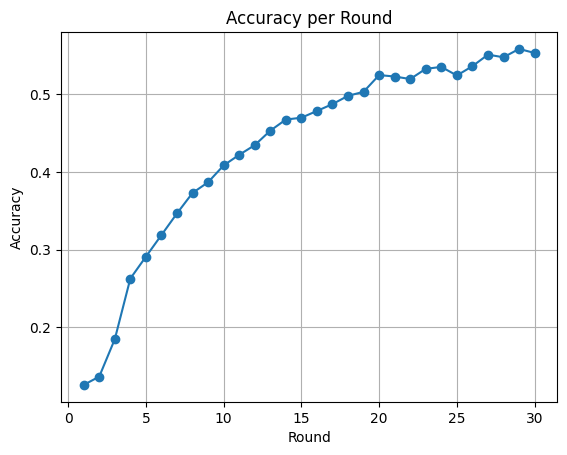

Classification Accuracy Matrix:
    Client 1  Client 2  Client 3  Client 4  Client 5  Client 6  Client 7  \
1        NaN     0.126       NaN     0.130       NaN       NaN     0.132   
2        NaN     0.128       NaN     0.140     0.138       NaN     0.132   
3        NaN     0.180       NaN     0.186     0.184       NaN     0.190   
4        NaN     0.244       NaN     0.270     0.270     0.276     0.264   
5      0.288     0.296       NaN     0.306     0.288     0.300     0.292   
6      0.288     0.302       NaN     0.324     0.306     0.330     0.292   
7      0.316     0.324     0.352     0.324     0.336     0.330     0.358   
8      0.352     0.348     0.352     0.332     0.336     0.376     0.376   
9      0.368     0.348     0.386     0.332     0.376     0.412     0.376   
10     0.384     0.364     0.414     0.332     0.392     0.438     0.376   
11     0.404     0.364     0.414     0.396     0.392     0.428     0.456   
12     0.404     0.400     0.414     0.422     0.412    

In [ ]:
CIFAR_10_iid_strategy_C = MethodC(0.5, NUM_CLIENTS, evaluate_fn=get_evaluate_server_fn(Net().to(DEVICE), testloader))

start_simulation(CIFAR_10_train_iid_loaders, CIFAR_10_test_iid_loaders, CIFAR_10_iid_strategy_C)
CIFAR_10_iid_strategy_C.save_accuracy_matrix(f'/content/drive/MyDrive/Colab Notebooks/graduation project/Week5/cifar10/iid_strategy_C_accuracy_matrix_clients={NUM_CLIENTS}_round={ROUND}.csv')
CIFAR_10_iid_strategy_C.probability_df.to_csv(f'/content/drive/MyDrive/Colab Notebooks/graduation project/Week5/cifar10/iid_strategy_C_probability_matrix_clients={NUM_CLIENTS}_round={ROUND}.csv')

### CIFAR 10 - Method C - non iid data

INFO :      Starting Flower simulation, config: num_rounds=30, no round_timeout
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-07-17 12:07:18,037	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'memory': 8028268955.0, 'object_store_memory': 4014134476.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      No `client_resources` specified. Using minimal resources for clients.
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO :      [INIT]
INFO :      Requesting initial parame

server_round: 1
Serial number of the client selected to fit: ['19', '12', '5', '0', '8', '15', '1', '7', '3', '16']


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (1, 720.9390480518341, {'accuracy': 0.1011}, 50.59006037200015)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Serial number of the client selected to evaluate: ['19', '12', '5', '0', '8', '15', '1', '7', '3', '16']


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 17 clients (out of 20)


server_round: 2
server_round: 2
Serial number of the client selected to fit: ['0', '1', '2', '3', '5', '6', '7', '8', '10', '11', '12', '13', '14', '15', '16', '17', '19']


INFO :      aggregate_fit: received 17 results and 0 failures
INFO :      fit progress: (2, 720.9405086040497, {'accuracy': 0.119}, 143.25062466500094)
INFO :      configure_evaluate: strategy sampled 17 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '1', '2', '3', '5', '6', '7', '8', '10', '11', '12', '13', '14', '15', '16', '17', '19']


INFO :      aggregate_evaluate: received 17 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 16 clients (out of 20)


server_round: 3
server_round: 3
Serial number of the client selected to fit: ['0', '1', '2', '5', '6', '7', '9', '10', '11', '13', '14', '15', '16', '17', '18', '19']


INFO :      aggregate_fit: received 16 results and 0 failures
INFO :      fit progress: (3, 720.7994999885559, {'accuracy': 0.1018}, 240.00191111200184)
INFO :      configure_evaluate: strategy sampled 16 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '1', '2', '5', '6', '7', '9', '10', '11', '13', '14', '15', '16', '17', '18', '19']


INFO :      aggregate_evaluate: received 16 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 15 clients (out of 20)


server_round: 4
server_round: 4
Serial number of the client selected to fit: ['0', '1', '2', '3', '5', '6', '7', '8', '9', '10', '12', '13', '14', '17', '19']


INFO :      aggregate_fit: received 15 results and 0 failures
INFO :      fit progress: (4, 721.3182144165039, {'accuracy': 0.1188}, 336.40829649400257)
INFO :      configure_evaluate: strategy sampled 15 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '1', '2', '3', '5', '6', '7', '8', '9', '10', '12', '13', '14', '17', '19']


INFO :      aggregate_evaluate: received 15 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 12 clients (out of 20)


server_round: 5
server_round: 5
Serial number of the client selected to fit: ['0', '3', '5', '7', '8', '9', '12', '13', '14', '17', '18', '19']


INFO :      aggregate_fit: received 12 results and 0 failures
INFO :      fit progress: (5, 733.6193482875824, {'accuracy': 0.1044}, 416.7853188350018)
INFO :      configure_evaluate: strategy sampled 12 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '3', '5', '7', '8', '9', '12', '13', '14', '17', '18', '19']


INFO :      aggregate_evaluate: received 12 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 19 clients (out of 20)


server_round: 6
server_round: 6
Serial number of the client selected to fit: ['0', '1', '2', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19']


INFO :      aggregate_fit: received 19 results and 0 failures
INFO :      fit progress: (6, 731.3764028549194, {'accuracy': 0.1039}, 517.7747768750014)
INFO :      configure_evaluate: strategy sampled 19 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '1', '2', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19']


INFO :      aggregate_evaluate: received 19 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 16 clients (out of 20)


server_round: 7
server_round: 7
Serial number of the client selected to fit: ['0', '1', '2', '4', '5', '6', '8', '9', '11', '12', '13', '14', '15', '16', '17', '18']


INFO :      aggregate_fit: received 16 results and 0 failures
INFO :      fit progress: (7, 714.0052673816681, {'accuracy': 0.1159}, 622.3991327479998)
INFO :      configure_evaluate: strategy sampled 16 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '1', '2', '4', '5', '6', '8', '9', '11', '12', '13', '14', '15', '16', '17', '18']


INFO :      aggregate_evaluate: received 16 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 16 clients (out of 20)


server_round: 8
server_round: 8
Serial number of the client selected to fit: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '12', '14', '15', '16', '18', '19']


INFO :      aggregate_fit: received 16 results and 0 failures
INFO :      fit progress: (8, 714.0005261898041, {'accuracy': 0.1632}, 721.6338072030012)
INFO :      configure_evaluate: strategy sampled 16 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '12', '14', '15', '16', '18', '19']


INFO :      aggregate_evaluate: received 16 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 15 clients (out of 20)


server_round: 9
server_round: 9
Serial number of the client selected to fit: ['0', '2', '3', '5', '7', '8', '9', '11', '12', '13', '14', '15', '16', '17', '18']


INFO :      aggregate_fit: received 15 results and 0 failures
INFO :      fit progress: (9, 714.1684136390686, {'accuracy': 0.1463}, 819.8783452880016)
INFO :      configure_evaluate: strategy sampled 15 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '2', '3', '5', '7', '8', '9', '11', '12', '13', '14', '15', '16', '17', '18']


INFO :      aggregate_evaluate: received 15 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 16 clients (out of 20)


server_round: 10
server_round: 10
Serial number of the client selected to fit: ['0', '1', '2', '3', '5', '7', '8', '9', '10', '11', '12', '13', '14', '16', '17', '18']


INFO :      aggregate_fit: received 16 results and 0 failures
INFO :      fit progress: (10, 692.1623153686523, {'accuracy': 0.2024}, 915.6808841880011)
INFO :      configure_evaluate: strategy sampled 16 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '1', '2', '3', '5', '7', '8', '9', '10', '11', '12', '13', '14', '16', '17', '18']


INFO :      aggregate_evaluate: received 16 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 11 clients (out of 20)


server_round: 11
server_round: 11
Serial number of the client selected to fit: ['0', '3', '5', '7', '8', '9', '12', '13', '14', '15', '19']


INFO :      aggregate_fit: received 11 results and 0 failures
INFO :      fit progress: (11, 695.9190472364426, {'accuracy': 0.2042}, 999.5597861429997)
INFO :      configure_evaluate: strategy sampled 11 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '3', '5', '7', '8', '9', '12', '13', '14', '15', '19']


INFO :      aggregate_evaluate: received 11 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 12 clients (out of 20)


server_round: 12
server_round: 12
Serial number of the client selected to fit: ['0', '3', '5', '6', '8', '11', '12', '14', '15', '16', '17', '18']


INFO :      aggregate_fit: received 12 results and 0 failures
INFO :      fit progress: (12, 717.2324731349945, {'accuracy': 0.1899}, 1070.8628678500027)
INFO :      configure_evaluate: strategy sampled 12 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '3', '5', '6', '8', '11', '12', '14', '15', '16', '17', '18']


INFO :      aggregate_evaluate: received 12 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 12 clients (out of 20)


server_round: 13
server_round: 13
Serial number of the client selected to fit: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '10', '13', '14']


INFO :      aggregate_fit: received 12 results and 0 failures
INFO :      fit progress: (13, 719.4576721191406, {'accuracy': 0.1751}, 1147.592305248003)
INFO :      configure_evaluate: strategy sampled 12 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '10', '13', '14']


INFO :      aggregate_evaluate: received 12 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 14 clients (out of 20)


server_round: 14
server_round: 14
Serial number of the client selected to fit: ['0', '2', '3', '5', '7', '8', '9', '11', '13', '15', '16', '17', '18', '19']


INFO :      aggregate_fit: received 14 results and 0 failures
INFO :      fit progress: (14, 688.1424168348312, {'accuracy': 0.2076}, 1231.9366462280013)
INFO :      configure_evaluate: strategy sampled 14 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '2', '3', '5', '7', '8', '9', '11', '13', '15', '16', '17', '18', '19']


INFO :      aggregate_evaluate: received 14 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 13 clients (out of 20)


server_round: 15
server_round: 15
Serial number of the client selected to fit: ['0', '1', '2', '3', '4', '6', '7', '9', '12', '13', '14', '15', '19']


INFO :      aggregate_fit: received 13 results and 0 failures
INFO :      fit progress: (15, 679.397980928421, {'accuracy': 0.227}, 1313.7147391610015)
INFO :      configure_evaluate: strategy sampled 13 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '1', '2', '3', '4', '6', '7', '9', '12', '13', '14', '15', '19']


INFO :      aggregate_evaluate: received 13 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 12 clients (out of 20)


server_round: 16
server_round: 16
Serial number of the client selected to fit: ['0', '1', '2', '3', '4', '6', '8', '10', '12', '16', '17', '18']


INFO :      aggregate_fit: received 12 results and 0 failures
INFO :      fit progress: (16, 709.1612969636917, {'accuracy': 0.2296}, 1393.7470094990022)
INFO :      configure_evaluate: strategy sampled 12 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '1', '2', '3', '4', '6', '8', '10', '12', '16', '17', '18']


INFO :      aggregate_evaluate: received 12 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 13 clients (out of 20)


server_round: 17
server_round: 17
Serial number of the client selected to fit: ['0', '1', '2', '3', '5', '7', '8', '10', '13', '14', '16', '17', '18']


INFO :      aggregate_fit: received 13 results and 0 failures
INFO :      fit progress: (17, 670.2883712053299, {'accuracy': 0.2017}, 1474.5845890279998)
INFO :      configure_evaluate: strategy sampled 13 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '1', '2', '3', '5', '7', '8', '10', '13', '14', '16', '17', '18']


INFO :      aggregate_evaluate: received 13 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 16 clients (out of 20)


server_round: 18
server_round: 18
Serial number of the client selected to fit: ['0', '2', '3', '4', '5', '6', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19']


INFO :      aggregate_fit: received 16 results and 0 failures
INFO :      fit progress: (18, 642.17152094841, {'accuracy': 0.2642}, 1567.5733865710026)
INFO :      configure_evaluate: strategy sampled 16 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '2', '3', '4', '5', '6', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19']


INFO :      aggregate_evaluate: received 16 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 9 clients (out of 20)


server_round: 19
server_round: 19
Serial number of the client selected to fit: ['0', '2', '4', '6', '7', '8', '11', '14', '15']


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      fit progress: (19, 648.2437156438828, {'accuracy': 0.2367}, 1646.5203375990022)
INFO :      configure_evaluate: strategy sampled 9 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '2', '4', '6', '7', '8', '11', '14', '15']


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 13 clients (out of 20)


server_round: 20
server_round: 20
Serial number of the client selected to fit: ['1', '2', '5', '6', '7', '9', '10', '12', '13', '15', '16', '18', '19']


INFO :      aggregate_fit: received 13 results and 0 failures
INFO :      fit progress: (20, 648.4917622804642, {'accuracy': 0.2221}, 1717.3200423000017)
INFO :      configure_evaluate: strategy sampled 13 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '2', '5', '6', '7', '9', '10', '12', '13', '15', '16', '18', '19']


INFO :      aggregate_evaluate: received 13 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 6 clients (out of 20)


server_round: 21
server_round: 21
Serial number of the client selected to fit: ['6', '7', '9', '11', '16', '18']


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (21, 697.9764097929001, {'accuracy': 0.214}, 1774.2314778300024)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 20)


Serial number of the client selected to evaluate: ['6', '7', '9', '11', '16', '18']


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 11 clients (out of 20)


server_round: 22
server_round: 22
Serial number of the client selected to fit: ['1', '2', '4', '5', '6', '9', '14', '15', '17', '18', '19']


INFO :      aggregate_fit: received 11 results and 0 failures
INFO :      fit progress: (22, 681.7350496053696, {'accuracy': 0.2247}, 1835.6548315600012)
INFO :      configure_evaluate: strategy sampled 11 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '2', '4', '5', '6', '9', '14', '15', '17', '18', '19']


INFO :      aggregate_evaluate: received 11 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 12 clients (out of 20)


server_round: 23
server_round: 23
Serial number of the client selected to fit: ['0', '1', '2', '3', '6', '7', '11', '15', '16', '17', '18', '19']


INFO :      aggregate_fit: received 12 results and 0 failures
INFO :      fit progress: (23, 625.6214643716812, {'accuracy': 0.2624}, 1907.172207566)
INFO :      configure_evaluate: strategy sampled 12 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '1', '2', '3', '6', '7', '11', '15', '16', '17', '18', '19']


INFO :      aggregate_evaluate: received 12 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 13 clients (out of 20)


server_round: 24
server_round: 24
Serial number of the client selected to fit: ['1', '3', '4', '5', '6', '7', '8', '12', '14', '16', '17', '18', '19']


INFO :      aggregate_fit: received 13 results and 0 failures
INFO :      fit progress: (24, 618.2885265350342, {'accuracy': 0.2674}, 1988.3072633850024)
INFO :      configure_evaluate: strategy sampled 13 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '3', '4', '5', '6', '7', '8', '12', '14', '16', '17', '18', '19']


INFO :      aggregate_evaluate: received 13 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 12 clients (out of 20)


server_round: 25
server_round: 25
Serial number of the client selected to fit: ['1', '2', '7', '9', '10', '11', '14', '15', '16', '17', '18', '19']


INFO :      aggregate_fit: received 12 results and 0 failures
INFO :      fit progress: (25, 618.6765477657318, {'accuracy': 0.2669}, 2065.877760798001)
INFO :      configure_evaluate: strategy sampled 12 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '2', '7', '9', '10', '11', '14', '15', '16', '17', '18', '19']


INFO :      aggregate_evaluate: received 12 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 13 clients (out of 20)


server_round: 26
server_round: 26
Serial number of the client selected to fit: ['0', '2', '3', '4', '5', '6', '7', '8', '10', '14', '15', '16', '19']


INFO :      aggregate_fit: received 13 results and 0 failures
INFO :      fit progress: (26, 624.9535475969315, {'accuracy': 0.2671}, 2143.6632602000027)
INFO :      configure_evaluate: strategy sampled 13 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '2', '3', '4', '5', '6', '7', '8', '10', '14', '15', '16', '19']


INFO :      aggregate_evaluate: received 13 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 12 clients (out of 20)


server_round: 27
server_round: 27
Serial number of the client selected to fit: ['0', '2', '4', '5', '7', '8', '9', '11', '15', '16', '17', '19']


INFO :      aggregate_fit: received 12 results and 0 failures
INFO :      fit progress: (27, 593.860080242157, {'accuracy': 0.3054}, 2224.5018781809995)
INFO :      configure_evaluate: strategy sampled 12 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '2', '4', '5', '7', '8', '9', '11', '15', '16', '17', '19']


INFO :      aggregate_evaluate: received 12 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 13 clients (out of 20)


server_round: 28
server_round: 28
Serial number of the client selected to fit: ['2', '3', '4', '6', '7', '9', '10', '11', '13', '15', '16', '18', '19']


INFO :      aggregate_fit: received 13 results and 0 failures
INFO :      fit progress: (28, 590.2625128030777, {'accuracy': 0.3283}, 2302.638923925002)
INFO :      configure_evaluate: strategy sampled 13 clients (out of 20)


Serial number of the client selected to evaluate: ['2', '3', '4', '6', '7', '9', '10', '11', '13', '15', '16', '18', '19']


INFO :      aggregate_evaluate: received 13 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 14 clients (out of 20)


server_round: 29
server_round: 29
Serial number of the client selected to fit: ['1', '2', '4', '5', '7', '9', '10', '11', '13', '15', '16', '17', '18', '19']


INFO :      aggregate_fit: received 14 results and 0 failures
INFO :      fit progress: (29, 592.8130053281784, {'accuracy': 0.3116}, 2384.432297047002)
INFO :      configure_evaluate: strategy sampled 14 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '2', '4', '5', '7', '9', '10', '11', '13', '15', '16', '17', '18', '19']


INFO :      aggregate_evaluate: received 14 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 13 clients (out of 20)


server_round: 30
server_round: 30
Serial number of the client selected to fit: ['0', '2', '3', '4', '6', '7', '9', '11', '12', '13', '14', '15', '16']


INFO :      aggregate_fit: received 13 results and 0 failures
INFO :      fit progress: (30, 576.4238115549088, {'accuracy': 0.3239}, 2468.1588271710025)
INFO :      configure_evaluate: strategy sampled 13 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '2', '3', '4', '6', '7', '9', '11', '12', '13', '14', '15', '16']


INFO :      aggregate_evaluate: received 13 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 30 round(s) in 2499.23s
INFO :      	History (loss, distributed):
INFO :      		round 1: 10.548395133018493
INFO :      		round 2: 10.377094366971184
INFO :      		round 3: 9.707685232162476
INFO :      		round 4: 9.946402470270792
INFO :      		round 5: 9.983540624380112
INFO :      		round 6: 9.758090916432833
INFO :      		round 7: 9.835332795977592
INFO :      		round 8: 9.650539584457874
INFO :      		round 9: 9.558320045471191
INFO :      		round 10: 8.911142565310001
INFO :      		round 11: 9.48404825817455
INFO :      		round 12: 9.420883605877558
INFO :      		round 13: 9.161082098881403
INFO :      		round 14: 8.842767383371081
INFO :      		round 15: 8.753222396740547
INFO :      		round 16: 8.216519723335901
INFO :      		round 17: 8.89845134661748
INFO :      		round 18: 8.71915066242218
INFO :      		round 19: 8.855611681938171
INFO :      		round

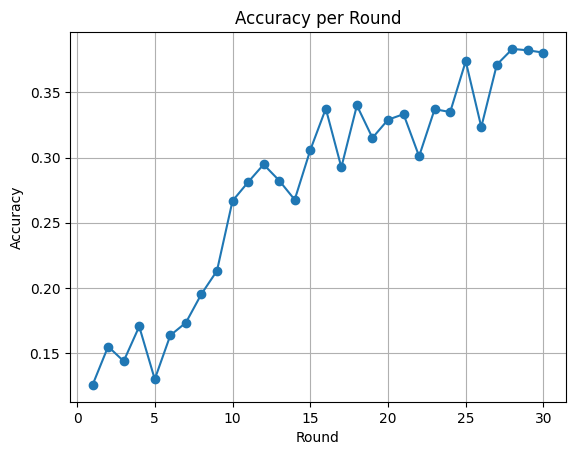

Classification Accuracy Matrix:
    Client 1  Client 2  Client 3  Client 4  Client 5  Client 6  Client 7  \
1   0.201754  0.104762       NaN  0.515464       NaN  0.023810       NaN   
2   0.219298  0.095238  0.246835  0.463918       NaN  0.023810  0.009174   
3   0.157895  0.019048  0.012658  0.463918       NaN  0.000000  0.027523   
4   0.175439  0.257143  0.259494  0.412371       NaN  0.047619  0.027523   
5   0.166667  0.257143  0.259494  0.237113       NaN  0.000000  0.027523   
6   0.052632  0.457143  0.063291  0.237113  0.061069  0.111111  0.036697   
7   0.149123  0.076190  0.056962  0.237113  0.167939  0.007937  0.018349   
8   0.219298  0.247619  0.132911  0.051546  0.198473  0.182540  0.302752   
9   0.175439  0.247619  0.031646  0.268041  0.198473  0.055556  0.302752   
10  0.122807  0.428571  0.196203  0.288660  0.198473  0.222222  0.302752   
11  0.228070  0.428571  0.196203  0.206186  0.198473  0.269841  0.302752   
12  0.271930  0.428571  0.196203  0.309278  0.198473  0.

In [ ]:
CIFAR_10_non_iid_strategy_C = MethodC(0.5, NUM_CLIENTS, evaluate_fn=get_evaluate_server_fn(Net().to(DEVICE), testloader))

start_simulation(CIFAR_10_train_non_iid_loaders, CIFAR_10_test_non_iid_loaders, CIFAR_10_non_iid_strategy_C)
CIFAR_10_non_iid_strategy_C.save_accuracy_matrix(f'/content/drive/MyDrive/Colab Notebooks/graduation project/Week5/cifar10/non_iid_strategy_C_accuracy_matrix_clients={NUM_CLIENTS}_round={ROUND}.csv')
CIFAR_10_non_iid_strategy_C.probability_df.to_csv(f'/content/drive/MyDrive/Colab Notebooks/graduation project/Week5/cifar10/non_iid_strategy_C_probability_matrix_clients={NUM_CLIENTS}_round={ROUND}.csv')

### CIFAR 10 - Method D - iid data

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
INFO :      Starting Flower simulation, config: num_rounds=30, no round_timeout


Initial p1 values:
Client 1: 0.5637005538048889
Client 2: 0.15336027278353082
Client 3: 0.1507504686199952
Client 4: 0.8691051966657654
Client 5: 0.004682638355565594
Client 6: 0.38488238866493163
Client 7: 0.17176474587062318
Client 8: 0.1757514625915837
Client 9: 0.5961588059957218
Client 10: 0.19889772542377482
Client 11: 0.36682062422252637
Client 12: 0.8753921891801177
Client 13: 0.9898801013024197
Client 14: 0.8365743977573442
Client 15: 0.9934569124298462
Client 16: 0.014401216664570282
Client 17: 0.04705575783328941
Client 18: 0.9760148109902966
Client 19: 0.9626889005188152
Client 20: 0.9536653886955329

Initial p2 values:
Client 1: 0.9088485553852735
Client 2: 0.5348710317826721
Client 3: 0.39516677350429863
Client 4: 0.3344904739110979
Client 5: 0.40129619051577325
Client 6: 0.6052193508273994
Client 7: 0.33980849433733984
Client 8: 0.03746106752824874
Client 9: 0.4787929094023292
Client 10: 0.3881380914332052
Client 11: 0.9663433297120534
Client 12: 0.007156492238716838
Cli

/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-07-17 12:49:27,387	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'CPU': 2.0, 'memory': 8028214887.0, 'object_store_memory': 4014107443.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      No `client_resources` specified. Using minimal resources for clients.
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=100129) 2024-07-17 12:49:35.937184: E external/

Serial number of the client selected to fit: ['2', '4', '5', '7', '8', '9', '11', '13', '15']


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      fit progress: (1, 720.0563533306122, {'accuracy': 0.107}, 80.69721531500181)
INFO :      configure_evaluate: strategy sampled 9 clients (out of 20)


Serial number of the client selected to evaluate: ['2', '4', '5', '7', '8', '9', '11', '13', '15']


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


Serial number of the client selected to fit: ['0', '1', '2', '4', '6', '7', '10', '12', '15', '19']


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (2, 718.0408725738525, {'accuracy': 0.1507}, 193.624769009999)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '1', '2', '4', '6', '7', '10', '12', '15', '19']


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 11 clients (out of 20)


Serial number of the client selected to fit: ['0', '1', '2', '4', '5', '6', '7', '8', '15', '16', '17']


INFO :      aggregate_fit: received 11 results and 0 failures
INFO :      fit progress: (3, 708.1126441955566, {'accuracy': 0.143}, 309.0749717719991)
INFO :      configure_evaluate: strategy sampled 11 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '1', '2', '4', '5', '6', '7', '8', '15', '16', '17']


INFO :      aggregate_evaluate: received 11 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 7 clients (out of 20)


Serial number of the client selected to fit: ['7', '8', '9', '10', '12', '15', '18']


INFO :      aggregate_fit: received 7 results and 0 failures
INFO :      fit progress: (4, 684.5354311466217, {'accuracy': 0.2151}, 401.4318526169991)
INFO :      configure_evaluate: strategy sampled 7 clients (out of 20)


Serial number of the client selected to evaluate: ['7', '8', '9', '10', '12', '15', '18']


INFO :      aggregate_evaluate: received 7 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 5 clients (out of 20)


Serial number of the client selected to fit: ['0', '5', '6', '7', '16']


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (5, 645.4852913618088, {'accuracy': 0.2478}, 466.1706072720008)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '5', '6', '7', '16']


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


Serial number of the client selected to fit: ['0', '4', '5', '6', '10', '12', '15', '17']


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (6, 612.2710305452347, {'accuracy': 0.2892}, 549.0130820109989)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '4', '5', '6', '10', '12', '15', '17']


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 6 clients (out of 20)


Serial number of the client selected to fit: ['0', '3', '5', '6', '15', '16']


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (7, 586.5933281183243, {'accuracy': 0.3175}, 627.350991629999)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '3', '5', '6', '15', '16']


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


Serial number of the client selected to fit: ['4', '5', '7', '8', '10', '12', '16', '19']


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (8, 562.0690733194351, {'accuracy': 0.3568}, 712.4535437679988)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)


Serial number of the client selected to evaluate: ['4', '5', '7', '8', '10', '12', '16', '19']


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 4 clients (out of 20)


Serial number of the client selected to fit: ['1', '6', '8', '10']


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (9, 540.6718100309372, {'accuracy': 0.372}, 788.8852871810013)
INFO :      configure_evaluate: strategy sampled 4 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '6', '8', '10']


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 4 clients (out of 20)


Serial number of the client selected to fit: ['4', '7', '10', '16']


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (10, 526.1726682186127, {'accuracy': 0.384}, 836.5508381860018)
INFO :      configure_evaluate: strategy sampled 4 clients (out of 20)


Serial number of the client selected to evaluate: ['4', '7', '10', '16']


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 6 clients (out of 20)


Serial number of the client selected to fit: ['0', '9', '15', '16', '18', '19']


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (11, 512.6765379905701, {'accuracy': 0.4009}, 903.256167841002)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '9', '15', '16', '18', '19']


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 7 clients (out of 20)


Serial number of the client selected to fit: ['1', '8', '9', '10', '12', '13', '16']


INFO :      aggregate_fit: received 7 results and 0 failures
INFO :      fit progress: (12, 498.62630558013916, {'accuracy': 0.4208}, 982.1582800920005)
INFO :      configure_evaluate: strategy sampled 7 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '8', '9', '10', '12', '13', '16']


INFO :      aggregate_evaluate: received 7 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 5 clients (out of 20)


Serial number of the client selected to fit: ['1', '4', '5', '15', '16']


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (13, 489.1552075147629, {'accuracy': 0.4285}, 1047.3968556280015)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '4', '5', '15', '16']


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 7 clients (out of 20)


Serial number of the client selected to fit: ['0', '1', '2', '4', '16', '17', '19']


INFO :      aggregate_fit: received 7 results and 0 failures
INFO :      fit progress: (14, 478.19142174720764, {'accuracy': 0.4476}, 1127.7959677159997)
INFO :      configure_evaluate: strategy sampled 7 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '1', '2', '4', '16', '17', '19']


INFO :      aggregate_evaluate: received 7 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 9 clients (out of 20)


Serial number of the client selected to fit: ['0', '1', '3', '5', '6', '8', '11', '15', '18']


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      fit progress: (15, 468.27850449085236, {'accuracy': 0.4581}, 1222.7133029569995)
INFO :      configure_evaluate: strategy sampled 9 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '1', '3', '5', '6', '8', '11', '15', '18']


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 5 clients (out of 20)


Serial number of the client selected to fit: ['10', '12', '17', '18', '19']


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (16, 460.83034551143646, {'accuracy': 0.4674}, 1297.5726099960011)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 20)


Serial number of the client selected to evaluate: ['10', '12', '17', '18', '19']


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 4 clients (out of 20)


Serial number of the client selected to fit: ['1', '4', '5', '13']


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (17, 454.6803072690964, {'accuracy': 0.4775}, 1348.7244575119985)
INFO :      configure_evaluate: strategy sampled 4 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '4', '5', '13']


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 4 clients (out of 20)


Serial number of the client selected to fit: ['0', '1', '15', '19']


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (18, 449.79946434497833, {'accuracy': 0.4786}, 1396.0229579840016)
INFO :      configure_evaluate: strategy sampled 4 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '1', '15', '19']


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 5 clients (out of 20)


Serial number of the client selected to fit: ['1', '4', '5', '12', '18']


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (19, 440.243842959404, {'accuracy': 0.493}, 1455.4887853559994)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '4', '5', '12', '18']


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 5 clients (out of 20)


Serial number of the client selected to fit: ['1', '4', '10', '16', '19']


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (20, 437.5019463300705, {'accuracy': 0.4948}, 1517.0150458290009)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '4', '10', '16', '19']


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


Serial number of the client selected to fit: ['0', '2', '5', '8', '9', '12', '16', '17']


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (21, 427.5024789571762, {'accuracy': 0.505}, 1598.5248534439997)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '2', '5', '8', '9', '12', '16', '17']


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 5 clients (out of 20)


Serial number of the client selected to fit: ['4', '5', '6', '9', '19']


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (22, 422.4611829519272, {'accuracy': 0.5135}, 1664.1188786589992)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 20)


Serial number of the client selected to evaluate: ['4', '5', '6', '9', '19']


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 7 clients (out of 20)


Serial number of the client selected to fit: ['0', '1', '2', '3', '4', '12', '15']


INFO :      aggregate_fit: received 7 results and 0 failures
INFO :      fit progress: (23, 416.96775126457214, {'accuracy': 0.5182}, 1745.4491994679993)
INFO :      configure_evaluate: strategy sampled 7 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '1', '2', '3', '4', '12', '15']


INFO :      aggregate_evaluate: received 7 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 4 clients (out of 20)


Serial number of the client selected to fit: ['1', '4', '8', '15']


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (24, 415.1566815972328, {'accuracy': 0.5268}, 1798.4569128219991)
INFO :      configure_evaluate: strategy sampled 4 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '4', '8', '15']


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 5 clients (out of 20)


Serial number of the client selected to fit: ['0', '9', '12', '15', '19']


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (25, 409.3619842529297, {'accuracy': 0.5256}, 1853.364920005999)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '9', '12', '15', '19']


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 5 clients (out of 20)


Serial number of the client selected to fit: ['0', '1', '10', '15', '17']


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (26, 406.60196805000305, {'accuracy': 0.5307}, 1916.6528764510003)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '1', '10', '15', '17']


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 4 clients (out of 20)


Serial number of the client selected to fit: ['0', '5', '9', '15']


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (27, 404.0132260918617, {'accuracy': 0.5386}, 1969.6596186860006)
INFO :      configure_evaluate: strategy sampled 4 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '5', '9', '15']


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 4 clients (out of 20)


Serial number of the client selected to fit: ['5', '6', '16', '17']


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (28, 397.7290390133858, {'accuracy': 0.5414}, 2017.6456906310013)
INFO :      configure_evaluate: strategy sampled 4 clients (out of 20)


Serial number of the client selected to evaluate: ['5', '6', '16', '17']


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 5 clients (out of 20)


Serial number of the client selected to fit: ['0', '5', '6', '12', '18']


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (29, 394.59669733047485, {'accuracy': 0.5439}, 2074.457436474)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '5', '6', '12', '18']


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 3 clients (out of 20)


Serial number of the client selected to fit: ['8', '14', '15']


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (30, 392.56986278295517, {'accuracy': 0.5487}, 2119.580634369002)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 20)


Serial number of the client selected to evaluate: ['8', '14', '15']


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 30 round(s) in 2127.31s
INFO :      	History (loss, distributed):
INFO :      		round 1: 36.79269708527459
INFO :      		round 2: 36.7082772731781
INFO :      		round 3: 36.23360638184981
INFO :      		round 4: 35.03641756943294
INFO :      		round 5: 33.21513404846191
INFO :      		round 6: 31.45042133331299
INFO :      		round 7: 30.316645840803783
INFO :      		round 8: 28.696870148181915
INFO :      		round 9: 27.55132582783699
INFO :      		round 10: 26.944752752780914
INFO :      		round 11: 26.51989398399989
INFO :      		round 12: 25.548900893756322
INFO :      		round 13: 24.810002279281616
INFO :      		round 14: 24.676108845642634
INFO :      		round 15: 24.009625408384537
INFO :      		round 16: 23.690606248378753
INFO :      		round 17: 22.890393272042274
INFO :      		round 18: 23.50141878426075
INFO :      		round 19: 22.605306482315065
INFO :    

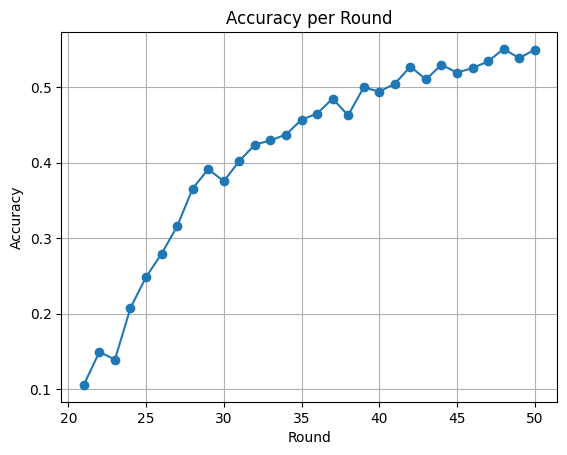

Classification Accuracy Matrix:
    Client 1  Client 2  Client 3  Client 4  Client 5  Client 6  Client 7  \
1        NaN       NaN     0.114       NaN     0.094     0.098       NaN   
2      0.130     0.140     0.176       NaN     0.150     0.098     0.154   
3      0.138     0.134     0.144       NaN     0.138     0.118     0.150   
4      0.138     0.134     0.144       NaN     0.138     0.118     0.150   
5      0.232     0.134     0.144       NaN     0.138     0.276     0.244   
6      0.268     0.134     0.144       NaN     0.278     0.294     0.290   
7      0.300     0.134     0.144     0.320     0.278     0.326     0.324   
8      0.300     0.134     0.144     0.320     0.334     0.380     0.324   
9      0.300     0.346     0.144     0.320     0.334     0.380     0.414   
10     0.300     0.346     0.144     0.320     0.352     0.380     0.414   
11     0.386     0.346     0.144     0.320     0.352     0.380     0.414   
12     0.386     0.396     0.144     0.320     0.352    

AttributeError: 'MethodD' object has no attribute 'availability_df_df'

In [ ]:
CIFAR_10_iid_strategy_D = MethodD(0.5, NUM_CLIENTS, evaluate_fn=get_evaluate_server_fn(Net().to(DEVICE), testloader))

start_simulation(CIFAR_10_train_iid_loaders, CIFAR_10_test_iid_loaders, CIFAR_10_iid_strategy_D)
CIFAR_10_iid_strategy_D.save_accuracy_matrix(f'/content/drive/MyDrive/Colab Notebooks/graduation project/Week5/cifar10/iid_strategy_D_accuracy_matrix_clients={NUM_CLIENTS}_round={ROUND}.csv')
CIFAR_10_iid_strategy_D.probability_df.to_csv(f'/content/drive/MyDrive/Colab Notebooks/graduation project/Week5/cifar10/iid_strategy_D_probability_matrix_clients={NUM_CLIENTS}_round={ROUND}.csv')

In [ ]:
CIFAR_10_iid_strategy_D.availability_df.to_csv(f'/content/drive/MyDrive/Colab Notebooks/graduation project/Week5/cifar10/iid_strategy_D_availability_matrix_clients={NUM_CLIENTS}_round={ROUND}.csv')


### CIFAR 10 - Method D - non iid data

INFO :      Starting Flower simulation, config: num_rounds=30, no round_timeout


Initial p1 values:
Client 1: 0.6003185655922711
Client 2: 0.5499758253223432
Client 3: 0.3502242147692033
Client 4: 0.5358200282161808
Client 5: 0.5413786286507595
Client 6: 0.675709716940811
Client 7: 0.41481367336619457
Client 8: 0.5800863868246509
Client 9: 0.043961837256691116
Client 10: 0.6879747783869006
Client 11: 0.7834478733836346
Client 12: 0.8587678620187752
Client 13: 0.15182984015404533
Client 14: 0.7342619022618093
Client 15: 0.017572790075235045
Client 16: 0.5138728420376576
Client 17: 0.2388402152853042
Client 18: 0.5837193603218306
Client 19: 0.6323252958747985
Client 20: 0.5144523764382805

Initial p2 values:
Client 1: 0.5974760790118365
Client 2: 0.69914836738136
Client 3: 0.7440179660859578
Client 4: 0.36693779080480615
Client 5: 0.9785579607234743
Client 6: 0.6510069814474202
Client 7: 0.0764143177483938
Client 8: 0.8163758420457448
Client 9: 0.5324832677107492
Client 10: 0.3914987985093058
Client 11: 0.013628410074494335
Client 12: 0.2972002719576473
Client 13: 0.

/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-07-17 14:29:45,935	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'memory': 8017937204.0, 'object_store_memory': 4008968601.0, 'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      No `client_resources` specified. Using minimal resources for clients.
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=126597) 2024-07-17 14:29:54.543198: E external/

Serial number of the client selected to fit: ['1', '8', '13', '16']


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (1, 721.7785816192627, {'accuracy': 0.1}, 25.457404049000615)
INFO :      configure_evaluate: strategy sampled 4 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '8', '13', '16']


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 4 clients (out of 20)


Serial number of the client selected to fit: ['6', '8', '16', '19']


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (2, 723.0010063648224, {'accuracy': 0.1}, 56.87586174199896)
INFO :      configure_evaluate: strategy sampled 4 clients (out of 20)


Serial number of the client selected to evaluate: ['6', '8', '16', '19']


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 4 clients (out of 20)


Serial number of the client selected to fit: ['1', '6', '8', '14']


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (3, 725.665403842926, {'accuracy': 0.1}, 87.0956032819995)
INFO :      configure_evaluate: strategy sampled 4 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '6', '8', '14']


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 7 clients (out of 20)


Serial number of the client selected to fit: ['4', '7', '8', '14', '15', '16', '19']


INFO :      aggregate_fit: received 7 results and 0 failures
INFO :      fit progress: (4, 736.3008377552032, {'accuracy': 0.1}, 127.5773706660002)
INFO :      configure_evaluate: strategy sampled 7 clients (out of 20)


Serial number of the client selected to evaluate: ['4', '7', '8', '14', '15', '16', '19']


INFO :      aggregate_evaluate: received 7 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 7 clients (out of 20)


Serial number of the client selected to fit: ['1', '4', '7', '8', '13', '14', '16']


INFO :      aggregate_fit: received 7 results and 0 failures
INFO :      fit progress: (5, 750.8891355991364, {'accuracy': 0.1}, 178.5382012480004)
INFO :      configure_evaluate: strategy sampled 7 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '4', '7', '8', '13', '14', '16']


INFO :      aggregate_evaluate: received 7 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 6 clients (out of 20)


Serial number of the client selected to fit: ['1', '5', '8', '12', '14', '18']


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (6, 753.7155575752258, {'accuracy': 0.1041}, 220.30727091299923)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '5', '8', '12', '14', '18']


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 7 clients (out of 20)


Serial number of the client selected to fit: ['4', '8', '12', '13', '15', '16', '18']


INFO :      aggregate_fit: received 7 results and 0 failures
INFO :      fit progress: (7, 824.042515039444, {'accuracy': 0.1}, 268.3423545919977)
INFO :      configure_evaluate: strategy sampled 7 clients (out of 20)


Serial number of the client selected to evaluate: ['4', '8', '12', '13', '15', '16', '18']


INFO :      aggregate_evaluate: received 7 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 5 clients (out of 20)


Serial number of the client selected to fit: ['4', '5', '14', '15', '19']


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (8, 828.6677663326263, {'accuracy': 0.1161}, 310.2946353410007)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 20)


Serial number of the client selected to evaluate: ['4', '5', '14', '15', '19']


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 4 clients (out of 20)


Serial number of the client selected to fit: ['2', '8', '16', '19']


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (9, 773.6358480453491, {'accuracy': 0.1217}, 343.9171892640006)
INFO :      configure_evaluate: strategy sampled 4 clients (out of 20)


Serial number of the client selected to evaluate: ['2', '8', '16', '19']


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 6 clients (out of 20)


Serial number of the client selected to fit: ['2', '4', '5', '8', '15', '16']


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (10, 743.2865536212921, {'accuracy': 0.152}, 382.66530371299814)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 20)


Serial number of the client selected to evaluate: ['2', '4', '5', '8', '15', '16']


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 4 clients (out of 20)


Serial number of the client selected to fit: ['2', '6', '8', '19']


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (11, 876.4982180595398, {'accuracy': 0.1452}, 418.5715220339989)
INFO :      configure_evaluate: strategy sampled 4 clients (out of 20)


Serial number of the client selected to evaluate: ['2', '6', '8', '19']


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 6 clients (out of 20)


Serial number of the client selected to fit: ['1', '4', '9', '13', '14', '16']


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (12, 726.9491555690765, {'accuracy': 0.1508}, 453.7007456559986)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '4', '9', '13', '14', '16']


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 6 clients (out of 20)


Serial number of the client selected to fit: ['0', '1', '7', '8', '14', '15']


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (13, 682.1460713148117, {'accuracy': 0.2082}, 497.2219834669995)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '1', '7', '8', '14', '15']


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 9 clients (out of 20)


Serial number of the client selected to fit: ['1', '2', '3', '4', '8', '9', '14', '16', '19']


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      fit progress: (14, 683.6079742908478, {'accuracy': 0.1957}, 548.5362528599981)
INFO :      configure_evaluate: strategy sampled 9 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '2', '3', '4', '8', '9', '14', '16', '19']


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 11 clients (out of 20)


Serial number of the client selected to fit: ['0', '2', '3', '5', '6', '7', '8', '9', '11', '14', '15']


INFO :      aggregate_fit: received 11 results and 0 failures
INFO :      fit progress: (15, 657.7164058685303, {'accuracy': 0.1994}, 609.9323655749977)
INFO :      configure_evaluate: strategy sampled 11 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '2', '3', '5', '6', '7', '8', '9', '11', '14', '15']


INFO :      aggregate_evaluate: received 11 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 5 clients (out of 20)


Serial number of the client selected to fit: ['1', '6', '16', '18', '19']


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (16, 716.1365267038345, {'accuracy': 0.1765}, 659.6641585149991)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '6', '16', '18', '19']


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 6 clients (out of 20)


Serial number of the client selected to fit: ['0', '2', '5', '6', '8', '16']


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (17, 724.2662973403931, {'accuracy': 0.1533}, 701.8679614779976)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '2', '5', '6', '8', '16']


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 4 clients (out of 20)


Serial number of the client selected to fit: ['1', '6', '14', '18']


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (18, 780.3642272949219, {'accuracy': 0.176}, 738.6485667479974)
INFO :      configure_evaluate: strategy sampled 4 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '6', '14', '18']


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


Serial number of the client selected to fit: ['0', '4', '5', '6', '7', '8', '16', '19']


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (19, 717.4300149679184, {'accuracy': 0.1592}, 781.1698962279988)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '4', '5', '6', '7', '8', '16', '19']


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 9 clients (out of 20)


Serial number of the client selected to fit: ['2', '4', '8', '9', '14', '15', '16', '18', '19']


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      fit progress: (20, 648.2334794998169, {'accuracy': 0.2248}, 841.3227368759981)
INFO :      configure_evaluate: strategy sampled 9 clients (out of 20)


Serial number of the client selected to evaluate: ['2', '4', '8', '9', '14', '15', '16', '18', '19']


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 6 clients (out of 20)


Serial number of the client selected to fit: ['2', '8', '13', '15', '16', '19']


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (21, 650.5417474508286, {'accuracy': 0.2046}, 893.4793633139998)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 20)


Serial number of the client selected to evaluate: ['2', '8', '13', '15', '16', '19']


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 6 clients (out of 20)


Serial number of the client selected to fit: ['1', '4', '7', '8', '13', '18']


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (22, 690.5040471553802, {'accuracy': 0.2133}, 932.824310699998)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '4', '7', '8', '13', '18']


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 5 clients (out of 20)


Serial number of the client selected to fit: ['2', '6', '8', '15', '19']


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (23, 751.2704336643219, {'accuracy': 0.1581}, 970.3093606820003)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 20)


Serial number of the client selected to evaluate: ['2', '6', '8', '15', '19']


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 5 clients (out of 20)


Serial number of the client selected to fit: ['1', '2', '8', '13', '16']


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (24, 661.6466139554977, {'accuracy': 0.2252}, 1011.753417527998)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '2', '8', '13', '16']


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


Serial number of the client selected to fit: ['1', '3', '4', '5', '7', '8', '13', '14', '15', '19']


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (25, 636.1419048309326, {'accuracy': 0.2411}, 1066.0402098939994)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 20)


Serial number of the client selected to evaluate: ['1', '3', '4', '5', '7', '8', '13', '14', '15', '19']


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 3 clients (out of 20)


Serial number of the client selected to fit: ['0', '8', '18']


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (26, 837.3046841621399, {'accuracy': 0.1883}, 1104.2444364090006)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '8', '18']


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 6 clients (out of 20)


Serial number of the client selected to fit: ['4', '7', '8', '14', '16', '19']


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (27, 655.58387362957, {'accuracy': 0.2073}, 1141.2602638450007)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 20)


Serial number of the client selected to evaluate: ['4', '7', '8', '14', '16', '19']


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 7 clients (out of 20)


Serial number of the client selected to fit: ['0', '1', '2', '3', '5', '8', '16']


INFO :      aggregate_fit: received 7 results and 0 failures
INFO :      fit progress: (28, 659.7406493425369, {'accuracy': 0.2429}, 1185.605773878)
INFO :      configure_evaluate: strategy sampled 7 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '1', '2', '3', '5', '8', '16']


INFO :      aggregate_evaluate: received 7 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 8 clients (out of 20)


Serial number of the client selected to fit: ['3', '4', '5', '7', '14', '15', '16', '19']


INFO :      aggregate_fit: received 8 results and 0 failures
INFO :      fit progress: (29, 618.3516688346863, {'accuracy': 0.255}, 1239.7485860929992)
INFO :      configure_evaluate: strategy sampled 8 clients (out of 20)


Serial number of the client selected to evaluate: ['3', '4', '5', '7', '14', '15', '16', '19']


INFO :      aggregate_evaluate: received 8 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 3 clients (out of 20)


Serial number of the client selected to fit: ['0', '8', '18']


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (30, 818.0715069770813, {'accuracy': 0.2202}, 1275.666126076998)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 20)


Serial number of the client selected to evaluate: ['0', '8', '18']


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 30 round(s) in 1281.39s
INFO :      	History (loss, distributed):
INFO :      		round 1: 11.930533528327942
INFO :      		round 2: 11.235808312892914
INFO :      		round 3: 11.286714434623718
INFO :      		round 4: 11.676075322287423
INFO :      		round 5: 11.406091383525304
INFO :      		round 6: 10.856005231539408
INFO :      		round 7: 11.47037672996521
INFO :      		round 8: 11.258442497253418
INFO :      		round 9: 11.355219900608063
INFO :      		round 10: 10.75118863582611
INFO :      		round 11: 10.479205757379532
INFO :      		round 12: 9.62752397855123
INFO :      		round 13: 9.749770085016886
INFO :      		round 14: 9.398171530829536
INFO :      		round 15: 8.685503114353526
INFO :      		round 16: 8.971795058250427
INFO :      		round 17: 9.249581237634024
INFO :      		round 18: 9.425629794597626
INFO :      		round 19: 9.033636212348938
INFO :     

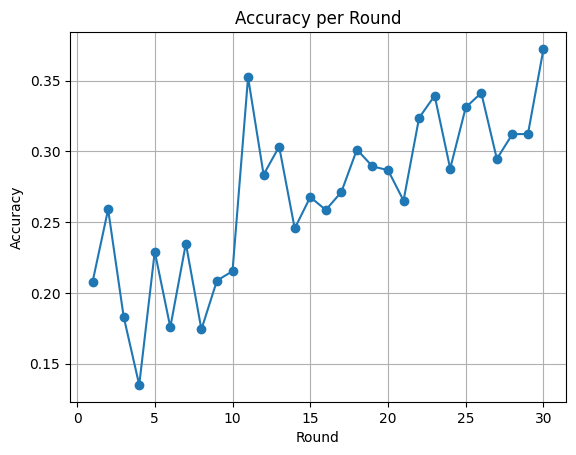

Classification Accuracy Matrix:
    Client 1  Client 2  Client 3  Client 4  Client 5  Client 6  Client 7  \
1        NaN  0.476190       NaN       NaN       NaN       NaN       NaN   
2        NaN  0.476190       NaN       NaN       NaN       NaN  0.458716   
3        NaN  0.009524       NaN       NaN       NaN       NaN  0.458716   
4        NaN  0.009524       NaN       NaN  0.274809       NaN  0.458716   
5        NaN  0.476190       NaN       NaN  0.053435       NaN  0.458716   
6        NaN  0.466667       NaN       NaN  0.053435  0.182540  0.458716   
7        NaN  0.466667       NaN       NaN  0.175573  0.182540  0.458716   
8        NaN  0.466667       NaN       NaN  0.045802  0.134921  0.458716   
9        NaN  0.466667  0.139241       NaN  0.045802  0.134921  0.458716   
10       NaN  0.466667  0.094937       NaN  0.297710  0.111111  0.458716   
11       NaN  0.466667  0.170886       NaN  0.297710  0.111111  0.467890   
12       NaN  0.476190  0.170886       NaN  0.061069  0.

In [ ]:
CIFAR_10_non_iid_strategy_D = MethodD(0.5, NUM_CLIENTS, evaluate_fn=get_evaluate_server_fn(Net().to(DEVICE), testloader))

start_simulation(CIFAR_10_train_non_iid_loaders, CIFAR_10_test_non_iid_loaders, CIFAR_10_non_iid_strategy_D)
CIFAR_10_non_iid_strategy_D.save_accuracy_matrix(f'/content/drive/MyDrive/Colab Notebooks/graduation project/Week5/cifar10/non_iid_strategy_D_accuracy_matrix_clients={NUM_CLIENTS}_round={ROUND}.csv')
CIFAR_10_non_iid_strategy_D.probability_df.to_csv(f'/content/drive/MyDrive/Colab Notebooks/graduation project/Week5/cifar10/non_iid_strategy_D_probability_matrix_clients={NUM_CLIENTS}_round={ROUND}.csv')
CIFAR_10_non_iid_strategy_D.availability_df.to_csv(f'/content/drive/MyDrive/Colab Notebooks/graduation project/Week5/cifar10/non_iid_strategy_D_availability_matrix_clients={NUM_CLIENTS}_round={ROUND}.csv')